In [1]:
from pandas import read_csv
from datetime import datetime
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import pandas as pd
import collections
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import pickle
from keras import backend as K


Using TensorFlow backend.


In [2]:
# load data

currencies = ['EURAUD', 'EURCAD', 'EURCHF', 'EURGBP', 'EURJPY', 'EURUSD', 'EURCZK', 'EURDKK', 'EURHKD', 'EURHUF', 'EURMXN', 'EURNOK', 'EURNZD', 'EURPLN', 'EURRUB', 'EURRUR', 'EURSEK', 'EURTRY', 'EURZAR']
#currencies = ['EURAUD', 'EURCAD', 'EURCHF', 'EURGBP', 'EURJPY', 'EURUSD', 'EURNZD']
#currencies = ['EURRUR']

def builData(currencies):
    
    print('Loading data and parsing date')
    
    def parse(x):
        return datetime.strptime(x, '%Y-%m-%d')
    
    ref = 'EURUSD'
    DF = read_csv(ref + '.csv', delimiter='\t')
    n_ref = len(DF['<DATE>'])
    
    keep = ['<DATE>', '<TIME>']
    
    for col in DF.columns:
        if col in keep:
            print('Reading col: ', col)
        else:
            DF.drop(col, axis=1, inplace=True)  
            print('Deleted col: ', col)
            
    df_arr = []

    limit = 24*365*8 # 5 years
    
    for curr in currencies:
        print('Reading currency: ', curr)
        
        df = read_csv(curr + '.csv', delimiter='\t')
        n_c = len(df['<DATE>'])
        #if n_c < limit:
        #    limit = n_c
        
        zeros = [0 for i in range(n_ref - n_c)]
        col = zeros + df['<CLOSE>'].tolist()

        DF[curr] = pd.Series(col)
      
        print('Data processed succesfully ')

        # dataset.index.name = 'date'

        # dataset.drop('Unnamed: 0', axis=1, inplace=True)

        # mark all NA values with 0
                
        
    for col in keep:
        DF.drop(col, axis=1, inplace=True) 
    DF = DF[-limit:]

    DF.info()
    print(DF.head(5))
    print(DF.tail(5))

    return DF

In [3]:
curr_key = currencies
df = builData(currencies)
df.to_pickle('EUR')

Loading data and parsing date
Reading col:  <DATE>
Reading col:  <TIME>
Deleted col:  <OPEN>
Deleted col:  <HIGH>
Deleted col:  <LOW>
Deleted col:  <CLOSE>
Deleted col:  <TICKVOL>
Deleted col:  <VOL>
Deleted col:  <SPREAD>
Reading currency:  EURAUD
Data processed succesfully 
Reading currency:  EURCAD
Data processed succesfully 
Reading currency:  EURCHF
Data processed succesfully 
Reading currency:  EURGBP
Data processed succesfully 
Reading currency:  EURJPY
Data processed succesfully 
Reading currency:  EURUSD
Data processed succesfully 
Reading currency:  EURCZK
Data processed succesfully 
Reading currency:  EURDKK
Data processed succesfully 
Reading currency:  EURHKD
Data processed succesfully 
Reading currency:  EURHUF
Data processed succesfully 
Reading currency:  EURMXN
Data processed succesfully 
Reading currency:  EURNOK
Data processed succesfully 
Reading currency:  EURNZD
Data processed succesfully 
Reading currency:  EURPLN
Data processed succesfully 
Reading currency:  EU

In [4]:
def prepareData(df):
    #creating train and test sets

    start = 24 * 30 * 18
    # df.columns.drop(['Unnamed: 0', 'date'])

    dataset = df.values

    dataset = np.array(dataset)
    dataset = dataset.astype(np.float64)
    print(dataset.shape)
    n_curr = len(df.columns)

    train_size = int(dataset.shape[0]*0.8)

    train = dataset[:train_size, :]
    valid = dataset[train_size:, :]
    #converting dataset into x_train and y_train
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(train)
    scaled_data_test = scaler.fit_transform(valid)

    x_train, y_train = [], []
    x_test, y_test = [], []

    lookback = 12
    for i in range(lookback,len(train)):
        x_train.append(scaled_data[i-lookback:i,:])
        y_train.append(scaled_data[i,:])
        
    for i in range(lookback,len(valid)):
        x_test.append(scaled_data_test[i-lookback:i,:])
        y_test.append(scaled_data_test[i,:])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], n_curr))
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], n_curr))
    
    #y_train = np.reshape(y_train, (y_train.shape[0],1))
    #y_test = np.reshape(y_test, (y_test.shape[0],1))
    
    #indices = np.arange(x_train.shape[0])
    #np.random.shuffle(indices)

    #x_train = x_train[indices, :, :]
    #y_train = y_train[indices, :]
    

    print(x_train.shape)
    
    print(y_train.shape)
    return x_train, y_train, x_test, y_test, scaler

In [5]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def buildModel(x_train, y_train, curr_key):
    i = 0
    units = 20
    epoc = 3
    batch = 1
    
    for curr in curr_key:
        # create and fit the LSTM network
        model = Sequential()
        #model.add(LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        model.add(LSTM(units=units))
        #model.add(Dropout(0.2))
        model.add(Dense(1))
        X = x_train[:, :, i].reshape(x_train.shape[0], x_train.shape[1], 1)
        y = y_train[:, i]
        
        

        model.compile(loss='mean_squared_error', optimizer='Adamax')
        history = model.fit(X, y, epochs=epoc, batch_size=batch, verbose=1)
        filename = curr + '_model.sav'
        pickle.dump(model, open(filename, 'wb'))
        print('Model created :', curr)
        

        i += 1
        
        
    print('Total created models: ', i)
    return [model]
    

In [6]:
def loadModel(curr_key):
    i = 0
    models = []
    for curr in curr_key:
        # load the model from disk
        filename = curr + '_model.sav'
        loaded_model = pickle.load(open(filename, 'rb'))
        models.append(loaded_model)
        print('Loaded model: ', filename)
    return models

In [7]:
def predict(x_test, models):
    predict_arr = np.zeros((x_test.shape[0], len(models)))

    i = 0
    for model in models:
        X = x_test[:, :, i].reshape(x_test.shape[0], x_test.shape[1], 1)
        
        prediction = model.predict(X)
        predict_arr[:, i] = prediction.reshape(prediction.shape[0],)
        i += 1
    return predict_arr

In [8]:
def getMSE(x_train, y_train, models, scaler):
    i = 0
    mse_arr = []
    ps = 0*y_train
    for model in models:
        X = x_train[:, :, i].reshape(x_train.shape[0], x_train.shape[1], 1)
        p = model.predict(X)
        ps[:, i] = p.reshape(p.shape[0],)
        i += 1

    y_train_inv = scaler.inverse_transform(y_train)
    predict = scaler.inverse_transform(ps)
        
    for j in range(len(models)):
        mse = mean_squared_error(y_train_inv[:, j], predict[:, j])
        mse_arr.append(mse)
    return mse_arr

In [9]:
df = pd.read_pickle('EUR')
df.tail(5)

,EURAUD,EURCAD,EURCHF,EURGBP,EURJPY,EURUSD,EURCZK,EURDKK,EURHKD,EURHUF,EURMXN,EURNOK,EURNZD,EURPLN,EURRUB,EURRUR,EURSEK,EURTRY,EURZAR
64830,1.64127,1.52070,1.06630,0.89472,120.338,1.12366,26.5660,7.45548,8.70796,344.209,24.96658,10.68226,1.73561,4.45787,78.296,78.295,10.48177,7.68706,19.3030
64831,1.64041,1.52241,1.06631,0.89461,120.489,1.12306,26.5720,7.45537,8.70328,344.180,25.02224,10.69146,1.73677,4.45940,78.265,78.386,10.47440,7.68212,19.2900
64832,1.63968,1.52161,1.06625,0.89565,120.445,1.12389,26.5829,7.45422,8.70952,344.220,25.07518,10.70436,1.74007,4.46166,78.200,78.296,10.48137,7.68548,19.3141
64833,1.63878,1.52086,1.06641,0.89548,120.282,1.12426,26.5790,7.45440,8.71246,344.652,25.03158,10.70561,1.74051,4.46220,78.157,78.265,10.47634,7.68667,19.3278
64834,1.63589,1.52230,1.06630,0.89488,120.278,1.12424,26.5467,7.45376,8.71205,344.838,25.01610,10.69145,1.74144,4.45920,78.148,78.227,10.46372,7.69242,19.3131


In [10]:
x_train, y_train, x_test, y_test, scaler = prepareData(df)

(64835, 19)
(51856, 12, 19)
(51856, 19)


In [11]:
print(curr_key)
models = buildModel(x_train, y_train, curr_key)

['EURAUD', 'EURCAD', 'EURCHF', 'EURGBP', 'EURJPY', 'EURUSD', 'EURCZK', 'EURDKK', 'EURHKD', 'EURHUF', 'EURMXN', 'EURNOK', 'EURNZD', 'EURPLN', 'EURRUB', 'EURRUR', 'EURSEK', 'EURTRY', 'EURZAR']
Epoch 1/3
51856/51856 [==============================] - 286s 6ms/step - loss: 1.2038e-04
Epoch 2/3
51856/51856 [==============================] - 283s 5ms/step - loss: 2.5281e-05
Epoch 3/3
51856/51856 [==============================] - 281s 5ms/step - loss: 2.4030e-05
Model created : EURAUD
Epoch 1/3
51856/51856 [==============================] - 285s 5ms/step - loss: 2.2118e-04
Epoch 2/3
51856/51856 [==============================] - 286s 6ms/step - loss: 2.7944e-05
Epoch 3/3
51856/51856 [==============================] - 287s 6ms/step - loss: 2.5912e-05
Model created : EURCAD
Epoch 1/3
51856/51856 [==============================] - 282s 5ms/step - loss: 1.3250e-04
Epoch 2/3
51856/51856 [==============================] - 282s 5ms/step - loss: 3.2626e-05
Epoch 3/3
51856/51856 [====================

In [12]:
curr_key = currencies
models = loadModel(curr_key)

Loaded model:  EURAUD_model.sav
Loaded model:  EURCAD_model.sav
Loaded model:  EURCHF_model.sav
Loaded model:  EURGBP_model.sav
Loaded model:  EURJPY_model.sav
Loaded model:  EURUSD_model.sav
Loaded model:  EURCZK_model.sav
Loaded model:  EURDKK_model.sav
Loaded model:  EURHKD_model.sav
Loaded model:  EURHUF_model.sav
Loaded model:  EURMXN_model.sav
Loaded model:  EURNOK_model.sav
Loaded model:  EURNZD_model.sav
Loaded model:  EURPLN_model.sav
Loaded model:  EURRUB_model.sav
Loaded model:  EURRUR_model.sav
Loaded model:  EURSEK_model.sav
Loaded model:  EURTRY_model.sav
Loaded model:  EURZAR_model.sav


In [13]:
predict_arr = predict(x_test, models)

In [14]:
horizon = 24*3

Plot currency  EURAUD


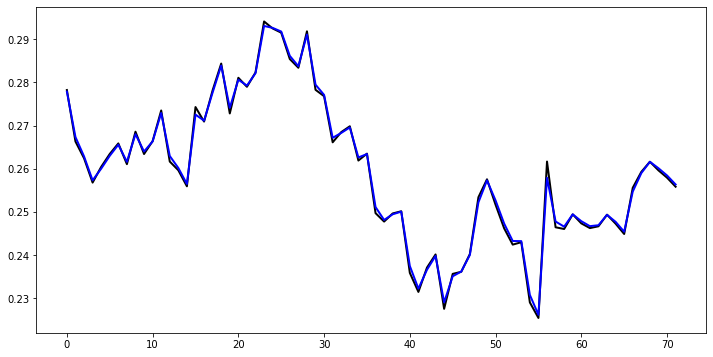

Plot currency  EURCAD


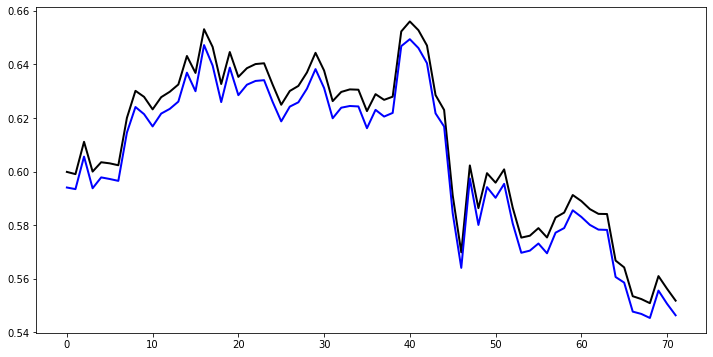

Plot currency  EURCHF


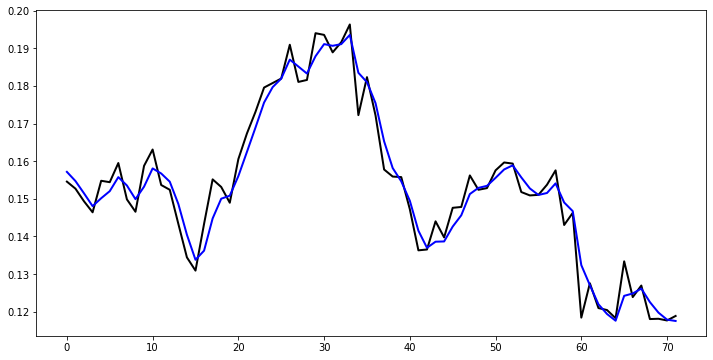

Plot currency  EURGBP


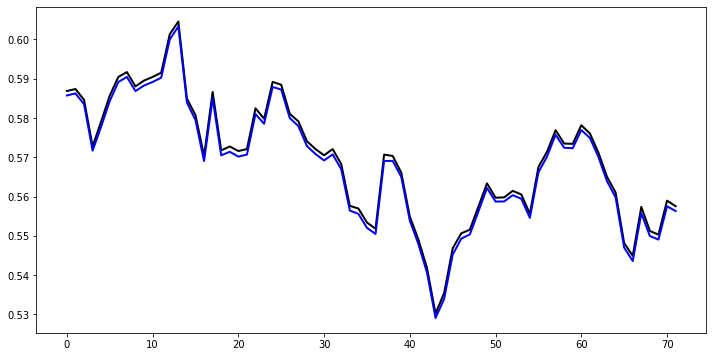

Plot currency  EURJPY


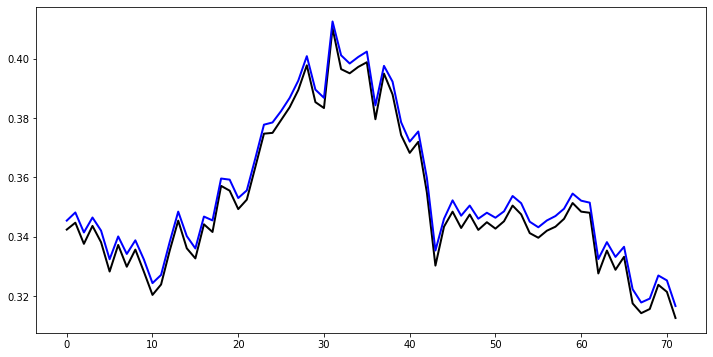

Plot currency  EURUSD


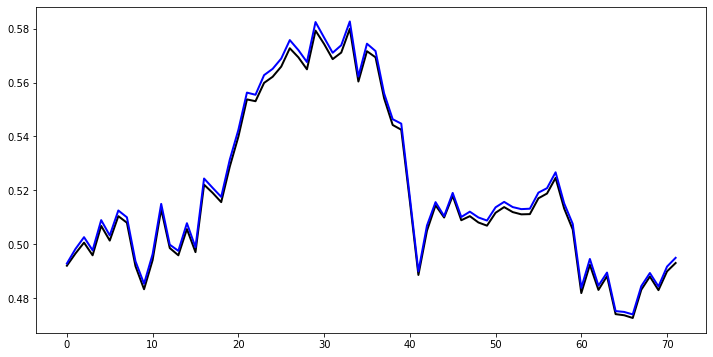

Plot currency  EURCZK


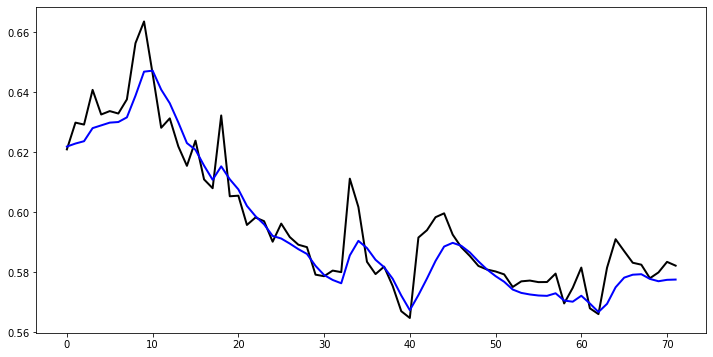

Plot currency  EURDKK


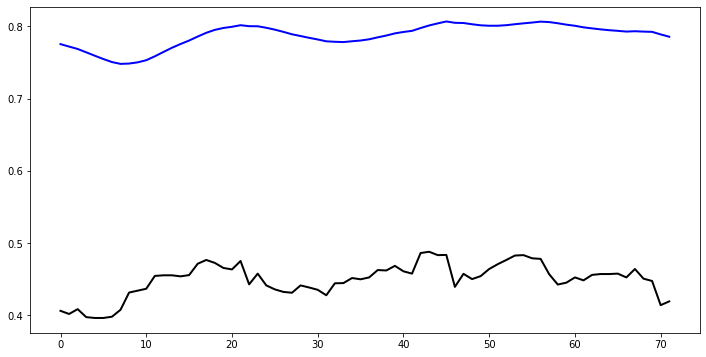

Plot currency  EURHKD


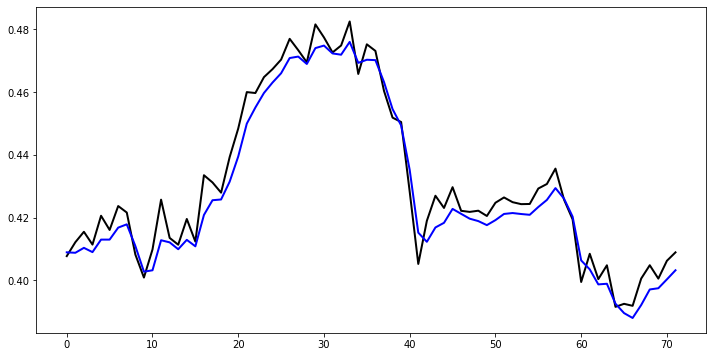

Plot currency  EURHUF


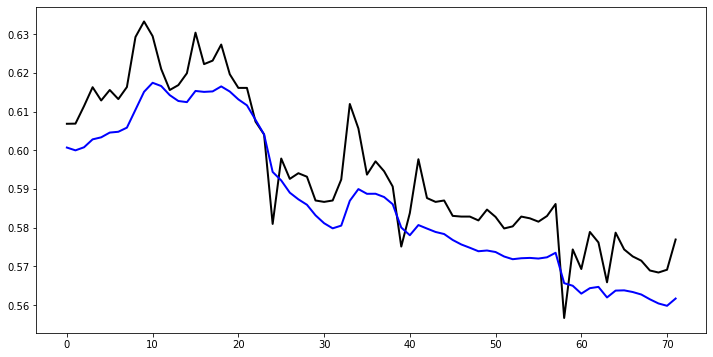

Plot currency  EURMXN


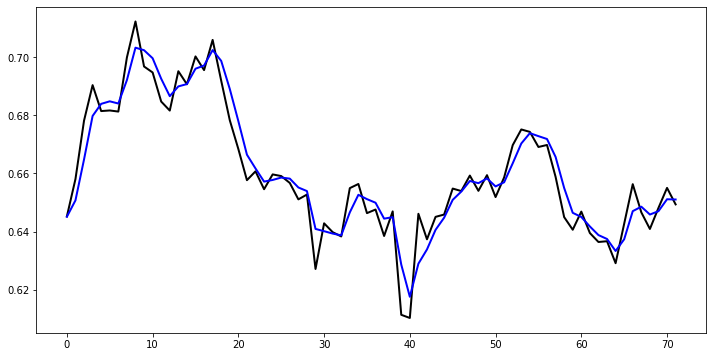

Plot currency  EURNOK


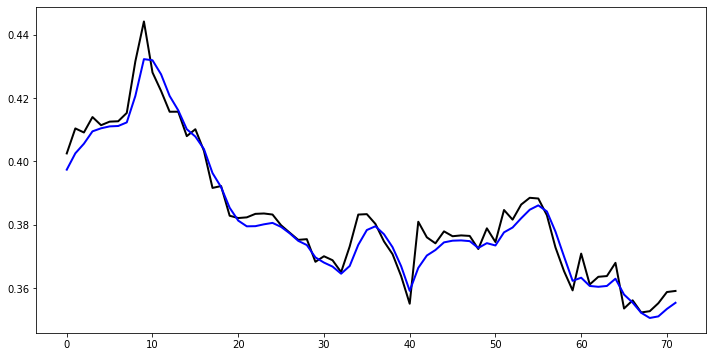

Plot currency  EURNZD


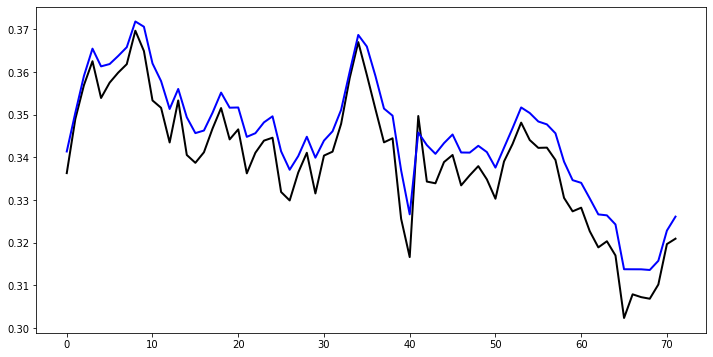

Plot currency  EURPLN


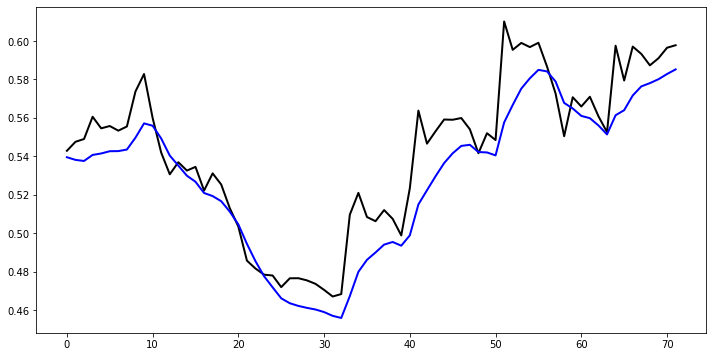

Plot currency  EURRUB


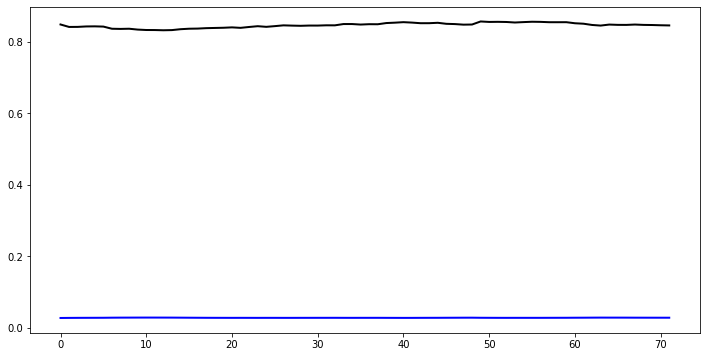

Plot currency  EURRUR


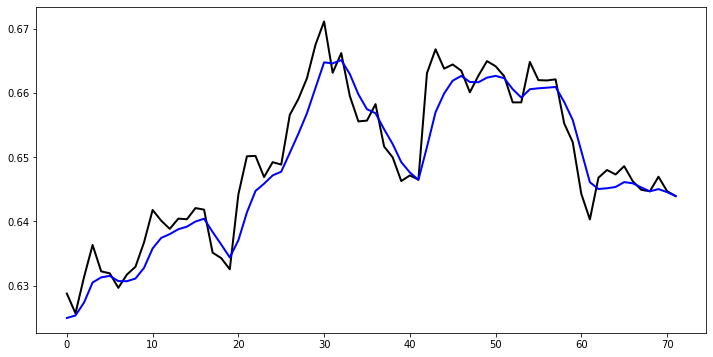

Plot currency  EURSEK


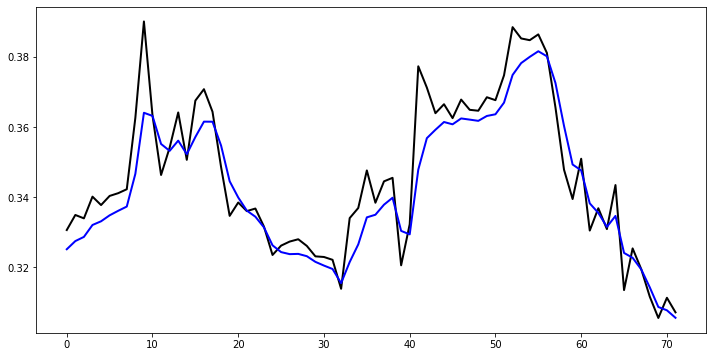

Plot currency  EURTRY


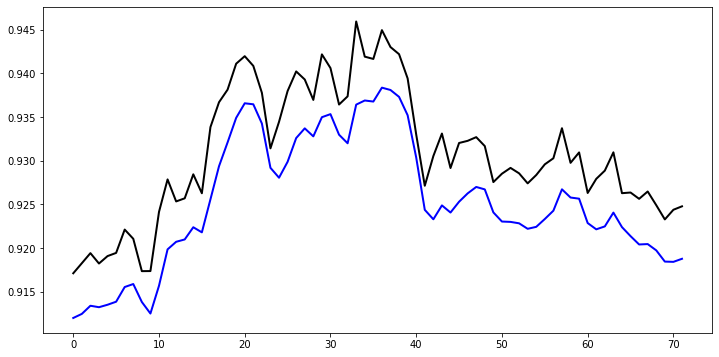

Plot currency  EURZAR


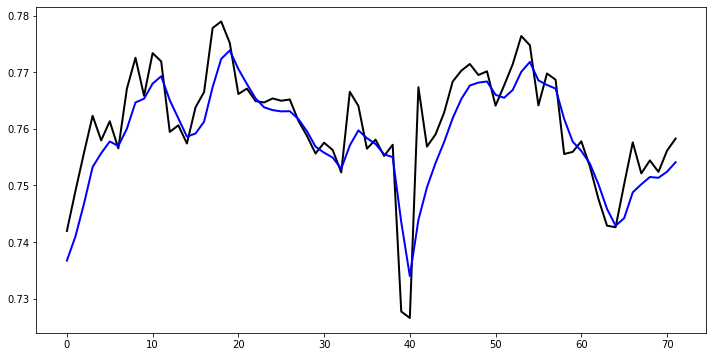

In [15]:
for i in range(len(curr_key)):
    xs = np.arange(int(horizon))
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    print('Plot currency ', curr_key[i])

    ax.plot(xs, y_test[-horizon-1:-1, i], label='Real ' + curr_key[i], lw=2, color='black')
    ax.plot(xs, predict_arr[-horizon:, i], label='Forecast ' + curr_key[i], lw=2, color='blue')
    
    plt.show()

In [16]:
y_test_inv = scaler.inverse_transform(y_test)
predict = scaler.inverse_transform(predict_arr)

horizon = 24*30*3

In [17]:
def getActions(y, V, Cash, T):
    n = V.shape[1]
    t_cur = T
    t_prev = t_cur - 1
    t_prev2 = t_prev - 1
    t_next = t_cur + 1
    
    X_eur = Cash[t_cur, -1]
    X_new = X_eur
    A = []
    
    gap_ref = 10/100
    
    for c in range(n):
        action = ''
        X = 0

        d_cur = y[t_cur, c] - y[t_prev, c]
        d_next = V[t_next, c] - y[t_prev, c]

        if d_cur > 0 and d_next < 0:
            action = 'BUY'

        elif d_cur < 0 and d_next > 0:
            action = 'SELL'
        A.append([action, X])
    
    return A

In [18]:
for j in range(len(curr_key)):
    mse = mean_squared_error(y_test[:, j], predict_arr[:, j])
    print(mse)

2.4618027518853194e-05
9.956348590023816e-05
3.5437507415109394e-05
5.938816792102752e-05
6.141198071923504e-05
7.453834773314502e-05
0.00012736449290202796
0.054258122761154826
7.35821889397414e-05
0.00028985509620733544
7.016891651469615e-05
3.2047898573522475e-05
0.0001554874728809911
0.0002831970602969288
0.4882710757581875
7.21578905075385e-05
0.00010158878849624036
4.662797954396523e-05
0.00010703168087980951


In [19]:
V = predict[-horizon:, :]
y = y_test_inv[-horizon-1:-1, :]

n = V.shape[1]
initial_cash = 1000
X_buy = 0*V
X_sell = 0*V

Cash = np.zeros((horizon+1, n + 1))
Cash[0, -1] = initial_cash
Cash[1, -1] = initial_cash
print('n ', n)

for t in range(2, horizon-1):
    A = getActions(y, V, Cash, t)
    Cash[t, :] = Cash[t-1, :]
    b = 0
    c = 0
    
    print('Jour ', t/24)
    for a in A:        
        if a[0] == 'SELL' and Cash[t, c] > 0:
            print(str(a[0]) + ' ' + str(Cash[t, c]) + ' ' + str(curr_key[c]) + ' rate :' + str(y[t, c]))
            
            Cash[t, -1] = Cash[t, -1] + Cash[t, c]/y[t, c]
            Cash[t, c] = Cash[t, c] -  Cash[t, c]
            X_sell[t, c] = 1
            
            
            print('Euro after sell ', Cash[t, -1])
        if a[0] == 'BUY':
            b += 1
        c += 1
          
    c = 0    
    for a in A:
            
        if a[0] == 'BUY' and Cash[t, -1] > 0:
            
            print(str(a[0]) + ' ' + str(Cash[t, -1]*y[t, c]/b) + ' ' + str(curr_key[c]) + ' rate: ' + str(y[t, c]/b))
            
            Cash[t, c] = Cash[t, c] + Cash[t, -1]*y[t, c]/b
            Cash[t, -1] = Cash[t, -1] - Cash[t, -1]/b
            
            print('Euro after buy ', Cash[t, -1])
            X_buy[t, c] = 1
        
        c += 1
    
    print('Actions end of hour: ', A)
    print('Accounts status: ', Cash[t, :])
    last_day = t

final_cash = Cash[last_day, -1]
print(final_cash)
for i in range(n):
    if y[last_day, i] != 0:
        final_cash += Cash[last_day, i]/y[last_day, i]
        initial_cash += Cash[0, i]/y[0, i]

d_growth = (final_cash/initial_cash)**(1/(horizon/24)) - 1
                 
print('Initial cash value (eur): ', initial_cash)
print('Final cash value (eur): ', final_cash)
print('Daily growth: ', d_growth, '%')
print('Win: ', final_cash - initial_cash)

n  19
Jour  0.08333333333333333
BUY 8277.333333333334 EURCZK rate: 8.277333333333335
Euro after buy  666.6666666666667
BUY 2230.4022222222225 EURNOK rate: 3.3456033333333335
Euro after buy  444.44444444444446
BUY 629.7481481481482 EURPLN rate: 1.4169333333333334
Euro after buy  296.2962962962963
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [   0.            0.            0.            0.            0.
    0.         8277.33333333    0.            0.            0.
    0.         2230.40222222    0.          629.74814815    0.
    0.            0.            0.            0.          296.2962963 ]
Jour  0.125
BUY 96.08829629629629 EURAUD rate: 0.324298
Euro after buy  237.03703703703704
BUY 3477.902222222222 EURRUB rate: 14.6724
Euro after buy  189.62962962962962
BUY 2740.4136296296297 EURRUR rate: 14.4

 1.22734391e+03 7.10733067e+02 1.87797289e+03 5.13421526e-01]
Jour  1.9166666666666667
BUY 1.596484233686265 EURCZK rate: 3.1094999999999997
Euro after buy  0.44924383485302527
BUY 0.4729229158333346 EURHKD rate: 1.0527087499999999
Euro after buy  0.3930883554963971
BUY 0.4928394393080515 EURNOK rate: 1.2537625
Euro after buy  0.3439523110593474
BUY 0.18262362925890463 EURPLN rate: 0.53095625
Euro after buy  0.300958272176929
BUY 2.6588910951151234 EURRUR rate: 8.83475
Euro after buy  0.26333848815481287
BUY 0.34671375771639795 EURSEK rate: 1.3166087499999999
Euro after buy  0.23042117713546126
BUY 0.18878435845355485 EURTRY rate: 0.8193012500000001
Euro after buy  0.2016185299935286
BUY 0.4071156964578077 EURZAR rate: 2.0192375
Euro after buy  0.17641621374433752
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0]]

Actions end of hour:  [['BUY', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['SELL', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0]]
Accounts status:  [5.79337810e-02 0.00000000e+00 1.98407876e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.51206893e+02 4.08119071e+04 0.00000000e+00 6.74471548e+02
 0.00000000e+00 1.14409728e+03 7.08769853e+03 3.32300594e+02
 1.22954464e+03 7.16292464e+02 1.88913151e+03 7.21761298e-02]
Jour  2.7916666666666665
SELL 0.057933781015920505 EURAUD rate :1.61185
Euro after sell  0.10811854444536685
BUY 0.022179747117649536 EURCAD rate: 0.2051428571428571
Euro after buy  0.09267303809602873
BUY 0.014083918769616755 EURCHF rate: 0.1519742857142857
Euro after buy  0.07943403265373891
BUY 0.012299792570483945 EURUSD rate: 0.15484285714285714
Euro after buy  0.06808631370320478
BUY 0.08189246733129092 EURHKD rate: 1.2027742857142858
Eur

BUY 8.980891189093979e-06 EURNOK rate: 5.03637
Euro after buy  8.916035943639942e-07
Actions end of hour:  [['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [0.00000000e+00 0.00000000e+00 1.72049530e-03 8.31954622e-04
 0.00000000e+00 1.49885516e-03 9.11273805e-01 0.00000000e+00
 8.51562608e+02 4.08270392e+04 6.32349090e-01 6.74587730e+02
 0.00000000e+00 1.14429026e+03 7.08842466e+03 3.32993896e+02
 1.22971991e+03 7.16359086e+02 1.88965453e+03 8.91603594e-07]
Jour  4.375
SELL 0.6323490897762308 EURMXN rate :20.059720000000002
Euro after sell  0.031524217441454054
BUY 0.3932330883646979 EURCZK rate: 12.474
Euro after buy  0.015762108720727027
BUY 0.5624393254817025 EURRUB rate: 35.683
Euro after buy  0.007881054360363514
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], [

 0.00000000e+00 7.41524206e+02 1.94647090e+03 1.69206974e-02]
Jour  5.25
SELL 56.02422103704184 EURCAD rate :1.42801
Euro after sell  39.24929374593768
BUY 2202.8666114907523 EURHUF rate: 56.125
Euro after buy  32.707744788281396
BUY 54.59745750074671 EURNOK rate: 1.6692516666666668
Euro after buy  27.256453990234498
BUY 19.377067415890874 EURPLN rate: 0.7109166666666668
Euro after buy  22.713711658528748
BUY 270.71715802078467 EURRUB rate: 11.918666666666667
Euro after buy  18.928093048773956
BUY 221.8561786246796 EURRUR rate: 11.721000000000002
Euro after buy  15.773410873978296
BUY 42.667470749383135 EURZAR rate: 2.7050249999999996
Euro after buy  13.14450906164858
Actions end of hour:  [['', 0], ['SELL', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0]]
Accounts status:  [0.00000000e+00 0.00000000e+00 4.13022786e-04 0.00000000e+00
 0.00000000e+00 5.822932

 0.00000000e+00 1.98246480e+00 2.02519147e+03 6.00084010e-01]
Jour  7.125
SELL 0.0028102389804022226 EURGBP rate :0.83642
Euro after sell  0.6034438516227636
BUY 0.8630152243982954 EURPLN rate: 1.43015
Euro after buy  0.40229590108184243
BUY 9.61165366864738 EURRUB rate: 23.892
Euro after buy  0.26819726738789496
BUY 1.4586391141971966 EURZAR rate: 5.438680000000001
Euro after buy  0.17879817825859662
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0]]
Accounts status:  [0.00000000e+00 0.00000000e+00 2.72750997e-03 0.00000000e+00
 0.00000000e+00 6.67341295e-03 1.42699115e+02 0.00000000e+00
 1.16392319e+03 8.87614858e+04 8.06549954e-02 7.97930092e+02
 0.00000000e+00 1.18612121e+03 8.05288975e+03 2.80969764e+01
 0.00000000e+00 1.98246480e+00 2.02665011e+03 1.78798178e-01]
Jour  7.166666666666667
BUY 0.8958468163833073 EURCZK rate: 

 1.89674213e+02 9.73195424e+01 2.33943488e+03 5.81086947e-02]
Jour  8.125
BUY 19.643644255187887 EURHUF rate: 338.05
Euro after buy  0.0
Actions end of hour:  [['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.64993549e-03
 0.00000000e+00 0.00000000e+00 1.50504301e+02 0.00000000e+00
 2.67372921e+01 9.46133387e+04 4.20180955e+00 8.18476669e+02
 0.00000000e+00 1.31184170e+03 8.11895793e+03 2.43281842e+03
 1.89674213e+02 9.73195424e+01 2.33943488e+03 0.00000000e+00]
Jour  8.166666666666666
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0]]
Accounts status:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.64993549e-03
 0.00000000e+0

Jour  10.083333333333334
BUY 0.0001031637134071454 EURCZK rate: 6.33425
Euro after buy  1.221498757632854e-05
BUY 0.00021647400982769438 EURRUR rate: 17.722
Euro after buy  9.161240682246405e-06
BUY 1.5337199475775998e-05 EURTRY rate: 1.6741400000000002
Euro after buy  6.870930511684803e-06
BUY 2.8595095057004226e-05 EURZAR rate: 4.16175
Euro after buy  5.153197883763603e-06
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['BUY', 0]]
Accounts status:  [0.00000000e+00 0.00000000e+00 2.69308628e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.78561974e+02 0.00000000e+00
 8.61906527e-05 9.50319371e+04 2.01355354e+00 8.67574046e+02
 0.00000000e+00 1.32443577e+03 8.12935047e+03 2.62790716e+03
 4.36770105e-03 6.55323029e-01 2.64949890e+03 5.15319788e-06]
Jour  10.125
BUY 1.0923942118922727e-05 EURHKD rate: 2.1198375
Euro after buy  3.86489841282

 1.44482793e-02 0.00000000e+00 2.64952915e+03 2.09203166e-04]
Jour  11.0
BUY 0.006326565251824839 EURJPY rate: 30.24125
Euro after buy  0.00015690237469908252
BUY 0.013284139553897822 EURHUF rate: 84.665
Euro after buy  0.00011767678102431189
BUY 0.0020804960693145778 EURRUB rate: 17.67975
Euro after buy  8.825758576823392e-05
BUY 0.00037444163338030923 EURZAR rate: 4.2426
Euro after buy  6.619318932617543e-05
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0]]
Accounts status:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.32656525e-03 0.00000000e+00 2.78628123e+02 0.00000000e+00
 9.25433279e-03 9.50331013e+04 0.00000000e+00 8.67577952e+02
 0.00000000e+00 1.32500487e+03 8.13435191e+03 2.62819016e+03
 1.44482793e-02 0.00000000e+00 2.64952952e+03 6.61931893e-05]
Jour  11.041666666666666
BUY 1.4109210691252947e-05 

 0.00000000e+00 2.63203582e+01 2.65541769e+03 0.00000000e+00]
Jour  13.125
Actions end of hour:  [['', 0], ['SELL', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0]]
Accounts status:  [1.36617137e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.27395878e+02 0.00000000e+00
 5.77623258e+01 9.85858343e+04 5.71255141e-01 0.00000000e+00
 0.00000000e+00 1.36311855e+03 9.33568454e+03 3.68277471e+03
 0.00000000e+00 2.63203582e+01 2.65541769e+03 0.00000000e+00]
Jour  13.166666666666666
SELL 0.013661713696756944 EURAUD rate :1.6904
Euro after sell  0.008081941372904014
BUY 0.0007846128283512392 EURGBP rate: 0.09708222222222222
Euro after buy  0.00718394788702579
BUY 0.0008895403738644901 EURUSD rate: 0.12382333333333334
Euro after buy  0.006385731455134036
BUY 0.018072400496318284 EURCZK rate: 2.830122222222222
Euro after buy  0.0056762057378969

Jour  14.083333333333334
BUY 0.11608628433449283 EURCZK rate: 5.079199999999999
Euro after buy  0.01828418401866323
BUY 0.07944167124980857 EURMXN rate: 4.34483
Euro after buy  0.014627347214930583
BUY 0.20626022307773612 EURRUB rate: 14.100999999999999
Euro after buy  0.011701877771944466
BUY 0.1653966808042175 EURRUR rate: 14.134200000000002
Euro after buy  0.009361502217555573
BUY 0.032225660773624605 EURZAR rate: 3.44236
Euro after buy  0.007489201774044459
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0]]
Accounts status:  [2.21027243e+00 8.54547861e-01 5.35285847e-05 0.00000000e+00
 0.00000000e+00 2.01897120e-02 8.27543159e+02 0.00000000e+00
 5.78885397e+01 9.89242020e+04 8.84280311e-01 6.17875027e-03
 0.00000000e+00 1.36466745e+03 9.37665060e+03 3.68295665e+03
 0.00000000e+00 0.00000000e+00 2.65558382e+03 7.48920177e-0

 5.82455291e-01 3.02636263e-01 2.65671780e+03 2.41682457e-03]
Jour  15.75
SELL 0.01822769196186578 EURCAD rate :1.4907499999999998
Euro after sell  0.014644020252745743
BUY 0.021000501310454247 EURPLN rate: 1.4340666666666666
Euro after buy  0.009762680168497163
BUY 0.23763339798138947 EURRUB rate: 24.340999999999998
Euro after buy  0.006508453445664775
BUY 0.022977313875506004 EURSEK rate: 3.5303799999999996
Euro after buy  0.004338968963776517
Actions end of hour:  [['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0]]
Accounts status:  [6.33781341e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.31145567e+02 0.00000000e+00
 6.01406833e+01 9.90196044e+04 1.53350234e-02 3.24934255e+00
 0.00000000e+00 1.36536093e+03 9.40117064e+03 3.70234558e+03
 6.05432605e-01 3.02636263e-01 2.65671780e+03 4.33896896e-03]
Jour  15.79

Euro after sell  0.0004935953689436551
BUY 0.002513387618661092 EURCZK rate: 5.0920000000000005
Euro after buy  0.0003948762951549241
BUY 0.026646252397054277 EURHUF rate: 67.47999999999999
Euro after buy  0.0003159010361239393
BUY 0.004651326855888882 EURRUB rate: 14.724
Euro after buy  0.0002527208288991514
BUY 0.0035599772283707865 EURRUR rate: 14.0866
Euro after buy  0.00020217666311932113
BUY 0.00042897884815990185 EURSEK rate: 2.121802
Euro after buy  0.0001617413304954569
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0]]
Accounts status:  [0.00000000e+00 1.22957343e-04 1.40148830e-02 2.79492675e-04
 0.00000000e+00 0.00000000e+00 8.57228416e+02 0.00000000e+00
 1.94055406e-02 9.98289282e+04 3.85523038e-01 0.00000000e+00
 0.00000000e+00 1.36762511e+03 9.50407052e+03 3.77345512e+03
 7.12682236e-01 2.82960608e-01 2.6710

Euro after buy  0.08686713055327079
BUY 4.868106385480757 EURHUF rate: 56.04083333333333
Euro after buy  0.072389275461059
BUY 0.13055490283556695 EURNOK rate: 1.8035116666666664
Euro after buy  0.06032439621754917
BUY 0.043424818239183864 EURPLN rate: 0.719855
Euro after buy  0.05027033018129097
BUY 0.6183501963949696 EURRUB rate: 12.3005
Euro after buy  0.04189194181774247
BUY 0.49280283956331644 EURRUR rate: 11.763666666666666
Euro after buy  0.034909951514785396
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['SELL', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [0.00000000e+00 1.82690045e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.44240228e+00 0.00000000e+00
 0.00000000e+00 1.24581356e+05 2.36904868e-01 1.31754154e-01
 3.10003297e-01 1.56199782e+03 1.13147543e+04 6.27958180e+03
 1.18332805e+00 9.64392101e+00 0.00000000e+00 3

Euro after buy  0.002270430634917639
BUY 0.0031895145785161083 EURTRY rate: 1.404806
Euro after buy  0.0018163445079341111
Actions end of hour:  [['SELL', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0]]
Accounts status:  [0.00000000e+00 1.92775245e-04 2.24699022e-03 0.00000000e+00
 8.47438435e-02 1.25770549e-03 5.43000141e+00 0.00000000e+00
 7.81672905e-03 1.24601534e+05 0.00000000e+00 2.87191614e-02
 2.28079433e-03 1.56224196e+03 1.13238831e+04 6.28136645e+03
 3.84047688e-02 9.73026240e+00 8.74764518e-01 1.81634451e-03]
Jour  19.791666666666668
SELL 0.0847438435399869 EURJPY rate :118.427
Euro after sell  0.0025319232487616833
BUY 0.14154168338831624 EURHUF rate: 55.90283333333333
Euro after buy  0.0021099360406347362
BUY 0.008431121557252884 EURMXN rate: 3.9959133333333328
Euro after buy  0.0017582800338622803
BUY 0.0012654019052367289 EURPLN ra

Euro after buy  8.750233726302888e-07
Actions end of hour:  [['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [2.13220840e-05 1.50238885e-04 0.00000000e+00 1.10885237e-06
 0.00000000e+00 1.19228753e-06 5.50905016e+00 0.00000000e+00
 4.34713687e-01 1.24735035e+05 1.31470169e+00 0.00000000e+00
 2.71566118e-04 1.56344913e+03 1.13262192e+04 6.29651141e+03
 9.69943984e-02 2.49084895e+00 1.28471410e+00 8.75023373e-07]
Jour  21.625
BUY 3.815831090811918e-06 EURCZK rate: 4.360833333333334
Euro after buy  7.291861438585741e-07
BUY 4.106180860194004e-05 EURHUF rate: 56.31183333333333
Euro after buy  6.076551198821451e-07
BUY 1.1383284381434874e-06 EURNOK rate: 1.8733133333333332
Euro after buy  5.063792665684542e-07
BUY 3.6885087759568347e-07 EURPLN rate: 0.7284083333333333
Euro after buy  4.219827221403785e-07
BUY 4.971659771350559e-06 EURRUR rate:

Jour  22.708333333333332
BUY 0.00018431845515550242 EURGBP rate: 0.30393333333333333
Euro after buy  0.0004042957998585269
BUY 0.046279201148739096 EURHUF rate: 114.46866666666666
Euro after buy  0.00026953053323901797
BUY 0.00634250266466949 EURRUR rate: 23.531666666666666
Euro after buy  0.0001796870221593453
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [8.14877438e-03 0.00000000e+00 4.24975087e-02 1.84318455e-04
 0.00000000e+00 0.00000000e+00 8.40487319e+00 0.00000000e+00
 1.42757952e-02 1.24767460e+05 0.00000000e+00 0.00000000e+00
 3.88274482e-04 1.56391549e+03 1.13334506e+04 6.30208545e+03
 0.00000000e+00 1.04134582e-03 7.33363218e-02 1.79687022e-04]
Jour  22.75
BUY 0.020606268118537507 EURHUF rate: 114.67866666666667
Euro after buy  0.00011979134810623021
BUY 0.00045819871207038106 EURNOK rate: 3.824973

Accounts status:  [2.33822737e-06 2.55943909e-09 0.00000000e+00 1.43680972e-08
 0.00000000e+00 2.10422516e-06 5.72418790e-03 0.00000000e+00
 1.08205424e-01 4.09009029e-01 1.62146681e-04 1.42052740e-08
 0.00000000e+00 2.35807586e+03 1.99532914e+04 8.93891525e+03
 0.00000000e+00 2.13719053e+02 3.38020410e-01 2.06678328e-09]
Jour  24.666666666666668
SELL 2.3382273699065853e-06 EURAUD rate :1.8294900000000003
Euro after sell  1.2801428426777107e-06
BUY 7.557067243179328e-05 EURJPY rate: 59.032999999999994
Euro after buy  6.400714213388553e-07
BUY 1.439997479799983e-06 EURPLN rate: 2.249745
Euro after buy  3.2003571066942766e-07
Actions end of hour:  [['SELL', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0]]
Accounts status:  [0.00000000e+00 2.55943909e-09 0.00000000e+00 1.43680972e-08
 7.55706724e-05 2.10422516e-06 5.72418790e-03 0.00000000e+00
 1.08205424e-01 4.09

 1.65925311e+00 6.14763791e+02 0.00000000e+00 0.00000000e+00]
Jour  25.875
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0]]
Accounts status:  [0.00000000e+00 1.40199267e+02 8.15399440e-01 5.74776144e+00
 0.00000000e+00 2.84632905e-01 0.00000000e+00 0.00000000e+00
 9.21330488e+02 0.00000000e+00 4.49411022e+02 3.18999394e+02
 0.00000000e+00 0.00000000e+00 3.38359754e+04 1.07959491e+04
 1.65925311e+00 6.14763791e+02 0.00000000e+00 0.00000000e+00]
Jour  25.916666666666668
Actions end of hour:  [['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [0.00000000e+00 1.40199267e+02 8.15399440e-01 5.74776144e+00
 0.00000000e+00 2.84632905e-01 0.00000000e+00 0.00000000e+00
 9.21330488e+02

SELL 0.0005505142402703795 EURPLN rate :4.60015
Euro after sell  28.757677369093415
BUY 10.71033681328094 EURAUD rate: 0.37243400000000004
Euro after buy  23.00614189527473
BUY 8.68307009868217 EURNZD rate: 0.3774240000000001
Euro after buy  18.404913516219786
BUY 259.2847406338011 EURRUB rate: 14.087799999999998
Euro after buy  14.723930812975828
BUY 206.6150315261646 EURRUR rate: 14.032599999999999
Euro after buy  11.779144650380662
BUY 44.990207409235936 EURZAR rate: 3.81948
Euro after buy  9.42331572030453
Actions end of hour:  [['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0]]
Accounts status:  [1.07103368e+01 1.25716641e-05 4.35179689e-05 0.00000000e+00
 2.94973383e-02 1.85017018e-04 0.00000000e+00 0.00000000e+00
 1.15740654e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.68307010e+00 0.00000000e+00 4.26186490e+04 2.48363260e+04
 

Jour  29.333333333333332
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['', 0]]
Accounts status:  [4.70081452e-01 0.00000000e+00 0.00000000e+00 8.97391978e+00
 0.00000000e+00 0.00000000e+00 2.97463597e+01 0.00000000e+00
 5.03429551e-02 6.41193757e+02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.29558283e+04 2.49887261e+04
 0.00000000e+00 0.00000000e+00 4.97322696e+01 0.00000000e+00]
Jour  29.375
Actions end of hour:  [['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [4.70081452e-01 0.00000000e+00 0.00000000e+00 8.97391978e+00
 0.00000000e+00 0.00000000e+00 2.97463597e+01 0.00000000e+00
 5.03429551e-02 6.41193757e+02 0.00000000e+00 0.00000000e+00
 0.0000

Euro after buy  0.22105708204515756
BUY 3.027818852772523 EURRUR rate: 13.697
Euro after buy  0.17684566563612605
BUY 0.6826543331186048 EURZAR rate: 3.86017
Euro after buy  0.14147653250890085
Actions end of hour:  [['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0]]
Accounts status:  [1.57396096e-01 2.73334607e-01 0.00000000e+00 6.65774729e-02
 0.00000000e+00 7.01397713e-02 4.71292736e-01 0.00000000e+00
 4.42129025e-01 0.00000000e+00 0.00000000e+00 7.19599061e-02
 1.27993432e-01 1.08214218e+00 4.35535946e+04 2.52312104e+04
 0.00000000e+00 7.78917573e-01 5.38747045e+01 1.41476533e-01]
Jour  31.5
SELL 0.07013977133251788 EURUSD rate :1.10018
Euro after sell  0.20522952868454292
BUY 0.729086109832986 EURTRY rate: 3.5525399999999996
Euro after buy  0.10261476434227146
BUY 0.9903730581300685 EURZAR rate: 9.65137
Euro after buy  0.05130738217113573
A

BUY 0.25699959182346144 EURRUB rate: 35.563
Euro after buy  0.003613300225282758
BUY 0.12546643037260585 EURRUR rate: 34.7235
Euro after buy  0.001806650112641379
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [0.00000000e+00 1.42383211e-02 1.13547530e-02 0.00000000e+00
 0.00000000e+00 8.21706930e-03 0.00000000e+00 0.00000000e+00
 5.23132089e-02 1.46002416e+01 0.00000000e+00 0.00000000e+00
 7.01228510e-03 1.26934601e+00 4.35634841e+04 2.54377739e+04
 1.52362741e-01 1.85777449e+00 2.72008835e-01 1.80665011e-03]
Jour  32.625
SELL 0.0142383211315755 EURCAD rate :1.5551700000000002
Euro after sell  0.010962125804414946
SELL 0.15236274108007178 EURSEK rate :11.033469999999998
Euro after sell  0.02477126663500331
BUY 4.448114421480957 EURHUF rate: 179.5675
Euro after buy  0.012385633317501655
BUY 0.43054938538299253 EUR

Euro after sell  3.4611988609364177
BUY 14.662849794527993 EURHKD rate: 4.23635
Euro after buy  1.7305994304682089
BUY 6.310388539282058 EURTRY rate: 3.6463599999999996
Euro after buy  0.8652997152341044
Actions end of hour:  [['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0]]
Accounts status:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.03582027e-02
 0.00000000e+00 3.45859518e+00 0.00000000e+00 0.00000000e+00
 9.25830567e+02 3.99045243e+03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.85345923e+01 4.60818715e+04 1.29789880e+04
 0.00000000e+00 1.21364793e+02 4.12011193e+01 8.65299715e-01]
Jour  34.708333333333336
SELL 3.458595183502227 EURUSD rate :1.09217
Euro after sell  4.032018434391586
Actions end of hour:  [['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], 

 0.00000000e+00 1.41626193e+02 0.00000000e+00 2.80366896e-01]
Jour  35.625
BUY 25.482617275507152 EURHUF rate: 90.89025
Euro after buy  0.21027517205234186
BUY 3.7407953108111616 EURRUB rate: 17.79
Euro after buy  0.15770637903925638
BUY 2.682151814915393 EURRUR rate: 17.00725
Euro after buy  0.11827978427944229
BUY 0.5970686628566465 EURZAR rate: 5.047935
Euro after buy  0.08870983820958171
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0]]
Accounts status:  [1.92405176e-01 1.55097140e-01 7.80341691e-01 3.53322227e+00
 0.00000000e+00 0.00000000e+00 5.79352670e-01 0.00000000e+00
 9.73860933e+02 1.40145248e+02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.63451144e+04 1.33766111e+04
 0.00000000e+00 1.41626193e+02 5.97068663e-01 8.87098382e-02]
Jour  35.666666666666664
SELL 0.7803416909473847 EURCHF rate :1.054

 1.71789839e-02 1.42070829e+02 1.05850045e-01 6.95038153e-06]
Jour  37.666666666666664
BUY 1.8770026599655917e-06 EURUSD rate: 0.2700575
Euro after buy  5.212786147298978e-06
BUY 1.0912498648617154e-05 EURHKD rate: 2.09341
Euro after buy  3.9095896104742334e-06
BUY 6.715599813651852e-05 EURRUR rate: 17.17725
Euro after buy  2.932192207855675e-06
BUY 5.3659557232590036e-06 EURTRY rate: 1.8300150000000002
Euro after buy  2.1991441558917563e-06
Actions end of hour:  [['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0]]
Accounts status:  [0.00000000e+00 8.69201772e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.87700266e-06 0.00000000e+00 0.00000000e+00
 9.75346045e+02 0.00000000e+00 2.85902669e-04 2.27435612e+00
 4.57496768e-03 0.00000000e+00 4.66751973e+04 1.34054942e+04
 1.71789839e-02 1.42070834e+02 1.05850045e-01 2.19914416e-06]
Jour  37.708

Actions end of hour:  [['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0]]
Accounts status:  [2.24161996e+01 4.99692048e+00 0.00000000e+00 2.17319593e+00
 9.86583232e+01 1.60885680e+01 0.00000000e+00 0.00000000e+00
 8.31372148e+01 0.00000000e+00 0.00000000e+00 7.39708819e+00
 0.00000000e+00 0.00000000e+00 4.92052486e+04 1.48281566e+04
 4.32647901e-04 2.41897386e+02 0.00000000e+00 1.35852850e+00]
Jour  38.791666666666664
SELL 4.996920480752233 EURCAD rate :1.52423
Euro after sell  4.636852954618873
SELL 7.397088190586997 EURNOK rate :11.15001
Euro after sell  5.30026834084606
BUY 361.6055072858815 EURRUR rate: 68.22399999999999
Euro after buy  0.0
Actions end of hour:  [['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['SELL', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0],

BUY 0.63576348953657 EURPLN rate: 1.1364325000000002
Euro after buy  0.4195784766384519
BUY 7.424126460259927 EURRUB rate: 17.69425
Euro after buy  0.3146838574788389
BUY 5.360954196009499 EURRUR rate: 17.035999999999998
Euro after buy  0.2360128931091292
Actions end of hour:  [['', 0], ['BUY', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['SELL', 0], ['SELL', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [2.50911168e+01 4.40623328e+00 7.93946290e+00 5.36664623e-02
 0.00000000e+00 5.32630617e-02 0.00000000e+00 0.00000000e+00
 6.40860152e+02 0.00000000e+00 0.00000000e+00 2.17011389e+00
 0.00000000e+00 6.35763490e-01 5.44775225e+04 2.63470816e+03
 3.11712694e+00 6.05419968e+02 1.36926458e+00 2.36012893e-01]
Jour  40.583333333333336
SELL 0.05326306170836 EURUSD rate :1.08578
Euro after sell  0.28506800713624336
SELL 640.8601521529757 EURHKD rate :8.41765
Euro after sell  76.41797352743892
BUY 1810.2

 0.00000000e+00 7.10575911e+02 4.30919002e+02 2.39855731e+00]
Jour  41.625
SELL 0.20096617378811032 EURNZD rate :1.7957499999999997
Euro after sell  2.5104694173914135
BUY 0.6390190696185061 EURCAD rate: 0.25454166666666667
Euro after buy  2.0920578478261778
BUY 2.957681649995056 EURHKD rate: 1.4137666666666666
Euro after buy  1.7433815398551482
BUY 102.54076259325024 EURHUF rate: 58.81716666666667
Euro after buy  1.4528179498792901
BUY 6.228857684214215 EURMXN rate: 4.2874316666666665
Euro after buy  1.2106816248994083
BUY 14.221473487151718 EURRUB rate: 11.746666666666668
Euro after buy  1.0089013540828402
BUY 3.314141739528979 EURZAR rate: 3.284901666666667
Euro after buy  0.8407511284023669
Actions end of hour:  [['', 0], ['BUY', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0]]
Accounts status:  [0.00000000e+00 5.34795807e+00 5.62297962e-01 1.53204589e-

Actions end of hour:  [['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [3.73379194e-01 6.42742850e-01 1.76459967e+01 0.00000000e+00
 0.00000000e+00 2.17046543e-01 1.68576890e+02 0.00000000e+00
 1.60984099e+02 2.26412328e+03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.54228213e+00 6.07066960e+04 3.85996424e+03
 0.00000000e+00 1.69080520e+02 9.74876890e+01 8.10353520e-02]
Jour  43.708333333333336
SELL 97.48768902712553 EURZAR rate :20.061
Euro after sell  4.940598136813234
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0]]
Accounts status:  [3.73379194e-01 6.42742850e-01 1.76459967e+01 0.00000000e+00
 0.00000000e+00 2.17046543e-01 1.68576890e+02 0.00000000e+00
 1.60984099e+02 2.26412328e+03 

Accounts status:  [5.79630425e-01 0.00000000e+00 6.59181272e+00 0.00000000e+00
 0.00000000e+00 6.02765829e+00 0.00000000e+00 0.00000000e+00
 2.21339971e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.06651582e-01 6.08851419e+04 3.95908737e+03
 8.44176529e-01 2.11579004e+02 1.61725559e+02 0.00000000e+00]
Jour  44.791666666666664
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [5.79630425e-01 0.00000000e+00 6.59181272e+00 0.00000000e+00
 0.00000000e+00 6.02765829e+00 0.00000000e+00 0.00000000e+00
 2.21339971e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.06651582e-01 6.08851419e+04 3.95908737e+03
 8.44176529e-01 2.11579004e+02 1.61725559e+02 0.00000000e+00]
Jour  44.833333333333336
SELL 0.3066515819014783 EURPLN rate :4.5223
Euro after sell  0.06780876587167553
BUY 0.0173235

 7.44806380e+01 2.23910169e+02 5.82659309e+01 5.69588952e+00]
Jour  46.958333333333336
BUY 1.9457272505467038 EURAUD rate: 0.34160199999999996
Euro after buy  4.5567116130390435
BUY 1.393141668300879 EURCAD rate: 0.305734
Euro after buy  3.6453692904312347
BUY 6.143650226242473 EURHKD rate: 1.68533
Euro after buy  2.9162954323449877
BUY 2.634756271306402 EURPLN rate: 0.9034599999999999
Euro after buy  2.33303634587599
BUY 3.510641107529588 EURTRY rate: 1.5047520000000003
Euro after buy  1.866429076700792
Actions end of hour:  [['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0]]
Accounts status:  [2.46167481e+00 1.39314167e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.74403153e+02 0.00000000e+00
 2.85796959e+02 1.71512050e+03 0.00000000e+00 1.96821519e+02
 2.05370992e+01 2.63475627e+00 6.18287468e+04 0.00000000e+00
 7.44806380

 0.00000000e+00 4.15332116e+02 1.97494313e+02 2.48951815e-01]
Jour  48.458333333333336
BUY 2.0906873810453463 EURHKD rate: 8.397960000000001
Euro after buy  0.0
Actions end of hour:  [['SELL', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [0.00000000e+00 4.29715416e-01 0.00000000e+00 2.59087884e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.32856585e+02 1.49900782e+02 0.00000000e+00 2.03515581e+00
 0.00000000e+00 0.00000000e+00 6.25658462e+04 0.00000000e+00
 0.00000000e+00 4.15332116e+02 1.97494313e+02 0.00000000e+00]
Jour  48.5
Actions end of hour:  [['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0]]
Accounts status:  [0.00000000e+00 4.29715416e-01 0.00000000e+00 2.5908788

SELL 0.012974012614366946 EURPLN rate :4.5414
Euro after sell  0.005990388633664111
BUY 0.009191951838925896 EURCAD rate: 1.53445
Euro after buy  0.0
Actions end of hour:  [['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [8.46812770e-03 1.25111096e+00 0.00000000e+00 3.00329944e-03
 0.00000000e+00 0.00000000e+00 4.97815706e-01 0.00000000e+00
 4.36499446e+01 7.19618229e+02 0.00000000e+00 9.18739505e-01
 2.10232372e-02 0.00000000e+00 6.32915048e+04 1.64345585e+02
 8.07832738e-02 5.41296643e+02 3.16748594e+02 0.00000000e+00]
Jour  50.416666666666664
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0]]
Accounts status:  [8.46812770e-03 1.25111096e+00 0.00000000e+00 3.00329944e-03
 0.000

 0.00000000e+00 5.56616543e+02 3.97092436e+00 3.87044755e-01]
Jour  51.75
BUY 0.878165843636645 EURPLN rate: 2.2689
Euro after buy  0.19352237728340715
BUY 0.7298502936866417 EURTRY rate: 3.7714
Euro after buy  0.09676118864170358
Actions end of hour:  [['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0]]
Accounts status:  [0.00000000e+00 9.99789550e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.53734199e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.85396497e+00 6.33392974e+04 1.17277407e+03
 0.00000000e+00 5.57346393e+02 3.97092436e+00 9.67611886e-02]
Jour  51.791666666666664
BUY 0.22307092202605605 EURNOK rate: 2.305376
Euro after buy  0.07740895091336286
BUY 0.0702653432872741 EURPLN rate: 0.9077160000000001
Euro after buy  0.06192716073069029
BUY 0.8416024997622273 EURRUB rate: 13.

 3.05454131e-02 5.77825400e+02 6.23758086e-01 3.66933588e-05]
Jour  54.208333333333336
BUY 0.00010285698882277418 EURHKD rate: 2.80315
Euro after buy  2.4462239224390227e-05
BUY 0.0005562550118031509 EURRUB rate: 22.739333333333335
Euro after buy  1.6308159482926818e-05
BUY 4.117266664122924e-05 EURTRY rate: 2.5246666666666666
Euro after buy  1.0872106321951213e-05
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0]]
Accounts status:  [0.00000000e+00 4.46002410e-01 2.43792251e+00 9.80835771e-04
 0.00000000e+00 1.87796332e+00 1.86648522e-01 0.00000000e+00
 6.02991728e+01 0.00000000e+00 0.00000000e+00 1.47050152e-03
 0.00000000e+00 1.74189137e+01 6.36651456e+04 4.72564777e+00
 3.05454131e-02 5.77825441e+02 6.23758086e-01 1.08721063e-05]
Jour  54.25
BUY 7.38052937665658e-05 EURCZK rate: 6.7885
Euro after buy  8.154079741463409e-0

Actions end of hour:  [['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['', 0]]
Accounts status:  [1.93211745e-01 5.89504917e+00 0.00000000e+00 6.08508233e-03
 0.00000000e+00 0.00000000e+00 1.86276214e+00 0.00000000e+00
 6.31918156e+01 1.66123393e+01 0.00000000e+00 2.38948391e+00
 0.00000000e+00 0.00000000e+00 6.38117103e+04 5.65712950e+00
 2.20395890e+00 5.84530651e+02 3.24043724e+00 1.35756864e-01]
Jour  55.333333333333336
SELL 2.3894839147368545 EURNOK rate :11.16841
Euro after sell  0.3497070959276001
SELL 2.203958895329828 EURSEK rate :10.683270000000002
Euro after sell  0.5560071234781373
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0]]
Accounts status:  [1.93211745e-01 5.89504917e+00

Actions end of hour:  [['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0]]
Accounts status:  [1.01691139e-02 1.19856480e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.74841032e+00 0.00000000e+00
 1.58359021e+01 7.66318405e+01 1.20765854e-01 1.06961644e+00
 0.00000000e+00 0.00000000e+00 6.91914000e+04 0.00000000e+00
 3.55058212e-01 7.04684618e+01 2.05885826e+00 9.82291800e-02]
Jour  57.583333333333336
BUY 0.03034377954353971 EURCAD rate: 0.308908
Euro after buy  0.07858334402097636
BUY 0.1332952684620127 EURHKD rate: 1.696228
Euro after buy  0.06286667521678109
BUY 0.05738344380437345 EURPLN rate: 0.91278
Euro after buy  0.05029334017342487
BUY 0.07737761148365868 EURTRY rate: 1.5385260000000003
Euro after buy  0.040234672138739894
BUY 0.16446807399496985 EURZAR rate: 4.08772
Euro after buy  0.03218773771099191
Actions end of hour

SELL 0.0013502004963519077 EURUSD rate :1.08318
Euro after sell  0.0016358001830611892
SELL 0.0006106194731518662 EURNZD rate :1.7901099999999999
Euro after sell  0.0019769074184555874
BUY 0.057299673070225966 EURJPY rate: 28.984499999999997
Euro after buy  0.0014826805638416905
BUY 0.004140604169911087 EURNOK rate: 2.7926474999999997
Euro after buy  0.0011120104228812678
BUY 0.019316455053264785 EURRUB rate: 17.37075
Euro after buy  0.0008340078171609509
BUY 0.0015986657993054256 EURTRY rate: 1.9168474999999998
Euro after buy  0.0006255058628707132
Actions end of hour:  [['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0]]
Accounts status:  [6.14784527e-03 2.22396134e-01 0.00000000e+00 8.62686829e-03
 5.72996731e-02 0.00000000e+00 4.43453884e-03 0.00000000e+00
 1.63293561e+01 7.94612976e+01 0.00000000e+00 1.25573613e+00
 0.00000000e+00 0.000

Euro after buy  1.466353602350208
BUY 6.346275746219535 EURMXN rate: 4.327929999999999
Euro after buy  1.22196133529184
BUY 0.36351313122706747 EURNZD rate: 0.2974833333333333
Euro after buy  1.0183011127432
BUY 0.7735524402953718 EURPLN rate: 0.75965
Euro after buy  0.8485842606193333
BUY 12.11071170613892 EURRUR rate: 14.271666666666667
Euro after buy  0.7071535505161111
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [6.29540865e-02 8.39239272e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.76379009e+00 0.00000000e+00
 0.00000000e+00 1.33541897e+02 6.35125110e+00 0.00000000e+00
 3.63513131e-01 7.75996706e-01 6.91987424e+04 1.22199496e+01
 8.03501960e-01 7.13656990e+01 2.72524190e+00 7.07153551e-01]
Jour  60.75
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 

 3.35891525e-01 7.63630271e+01 3.70992045e+00 8.19216292e-03]
Jour  62.041666666666664
SELL 0.015312872845328618 EURAUD rate :1.65986
Euro after sell  0.01741756315837966
BUY 0.02437767945501203 EURHKD rate: 1.3996033333333333
Euro after buy  0.014514635965316384
BUY 0.8442679919825696 EURHUF rate: 58.166666666666664
Euro after buy  0.012095529971096987
BUY 0.14012066695017306 EURRUB rate: 11.5845
Euro after buy  0.010079608309247489
BUY 0.01779701001318128 EURSEK rate: 1.765645
Euro after buy  0.008399673591039575
BUY 0.010741656582237245 EURTRY rate: 1.2788183333333334
Euro after buy  0.006999727992532979
BUY 0.02316979962808342 EURZAR rate: 3.3101000000000003
Euro after buy  0.005833106660444149
Actions end of hour:  [['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0]]
Accounts status:  [0.00000000e+00 2.25241453e-02 0.00000000e+00 2.07632517e-

 3.23958051e-02 7.70537343e+01 7.92339149e-03 0.00000000e+00]
Jour  64.33333333333333
SELL 0.007923391492044797 EURZAR rate :19.92436
Euro after sell  0.000397673576066925
BUY 0.00015184171318175367 EURCAD rate: 0.3818250000000001
Euro after buy  0.00029825518205019375
BUY 0.026168909673084 EURHUF rate: 87.74
Euro after buy  0.0002236913865376453
BUY 0.0006156479078566382 EURNOK rate: 2.75222
Euro after buy  0.000167768539903234
BUY 0.0004444343807936078 EURSEK rate: 2.6490924999999996
Euro after buy  0.0001258264049274255
Actions end of hour:  [['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['SELL', 0]]
Accounts status:  [0.00000000e+00 7.44379830e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.63176723e-05 2.06968448e-02 0.00000000e+00
 8.45088780e-01 3.04967827e+02 4.26517673e-04 6.98205213e-02
 0.00000000e+00 0.00000000e+00 6.92511831e+04 2.93923821

Jour  65.625
SELL 0.10746679396161106 EURMXN rate :26.1599
Euro after sell  0.007715281578479718
BUY 0.0029402938095586207 EURCAD rate: 0.3811
Euro after buy  0.005786461183859788
BUY 0.5128916667231881 EURHUF rate: 88.6365
Euro after buy  0.004339845887894841
BUY 0.01200200654719398 EURNOK rate: 2.7655375
Euro after buy  0.003254884415921131
BUY 0.06306582672178385 EURRUB rate: 19.37575
Euro after buy  0.0024411633119408483
Actions end of hour:  [['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [9.48320238e-02 9.53023204e-02 3.99838891e-03 6.24751517e-03
 0.00000000e+00 0.00000000e+00 1.55378794e-01 0.00000000e+00
 2.06221654e+00 4.91131896e+01 0.00000000e+00 1.20020065e-02
 0.00000000e+00 2.16570782e-02 6.92724008e+04 3.08998622e+00
 9.78133924e-01 7.73474374e+01 5.52609389e-03 2.44116331e-03]
Jour  65.66666666666667
BUY 0

BUY 0.004971166406481452 EURTRY rate: 1.2418183333333335
Euro after buy  0.003335945814995384
Actions end of hour:  [['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0]]
Accounts status:  [0.00000000e+00 2.70344179e-03 1.74553000e-03 5.44193350e-03
 0.00000000e+00 0.00000000e+00 1.72608523e-01 0.00000000e+00
 2.84377633e+00 6.11829125e+01 0.00000000e+00 1.05997602e-02
 0.00000000e+00 0.00000000e+00 6.92746665e+04 0.00000000e+00
 4.83398279e-02 7.80147756e+01 1.19828455e-01 3.33594581e-03]
Jour  67.33333333333333
BUY 0.018439640649135884 EURCZK rate: 5.527559999999999
Euro after buy  0.002668756651996307
BUY 0.005889508254864923 EURNOK rate: 2.206836
Euro after buy  0.0021350053215970456
BUY 0.03474721160899192 EURRUB rate: 16.275
Euro after buy  0.0017080042572776364
BUY 0.0036368671290553296 EURSEK rate: 2.129308
Euro after buy  0.0013664034058221

Jour  68.45833333333333
SELL 0.06676461758249168 EURNOK rate :10.92746
Euro after sell  0.010098106779053267
SELL 0.000660952497519839 EURNZD rate :1.7981200000000002
Euro after sell  0.01046568652763503
BUY 0.07203793679134382 EURCZK rate: 6.88325
Euro after buy  0.007849264895726273
BUY 0.6904802097148008 EURHUF rate: 87.9675
Euro after buy  0.005886948671794704
BUY 0.0067106505299522196 EURPLN rate: 1.13992
Euro after buy  0.004415211503846028
BUY 0.09558491384676267 EURRUB rate: 21.649
Euro after buy  0.003311408627884521
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['SELL', 0], ['SELL', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [0.00000000e+00 9.28445666e-03 0.00000000e+00 2.13514061e-03
 0.00000000e+00 0.00000000e+00 7.20379368e-02 0.00000000e+00
 2.95980641e+00 3.44257353e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.14292023e-03 6.92794616e+04

Jour  69.91666666666667
BUY 0.00015852039891777272 EURCZK rate: 9.102666666666666
Euro after buy  1.1609813894666232e-05
BUY 0.001352930312525105 EURHUF rate: 116.53333333333335
Euro after buy  7.739875929777487e-06
BUY 0.00021994921421377334 EURRUB rate: 28.417666666666662
Euro after buy  5.159917286518325e-06
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [0.00000000e+00 4.93184133e-04 1.45822014e-05 3.90430803e-03
 0.00000000e+00 0.00000000e+00 1.58520399e-04 0.00000000e+00
 2.96326627e+00 3.56808639e+01 5.44609386e-02 1.16023818e-03
 0.00000000e+00 1.10926327e-04 6.92796140e+04 6.35546300e-03
 1.38829362e-02 7.81064025e+01 1.90444466e-01 5.15991729e-06]
Jour  69.95833333333333
BUY 3.2785159853839426e-05 EURMXN rate: 6.353815
Euro after buy  3.8699379648887435e-06
BUY 8.284569698335577e-05 EURRUB rate: 21.40

 1.49269900e-02 7.81126906e+01 1.94632129e-01 1.06858808e-06]
Jour  71.08333333333333
SELL 1.090241600806715e-05 EURAUD rate :1.66962
Euro after sell  7.598466742387762e-06
BUY 0.0008810422187798612 EURHUF rate: 115.95
Euro after buy  5.065644494925174e-06
BUY 1.8380049401533306e-05 EURNOK rate: 3.6283733333333337
Euro after buy  3.377096329950116e-06
BUY 1.1856726303736227e-05 EURSEK rate: 3.510923333333333
Euro after buy  2.2513975533000776e-06
Actions end of hour:  [['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0]]
Accounts status:  [0.00000000e+00 1.67914227e-05 3.80349405e-05 2.13673599e-05
 0.00000000e+00 0.00000000e+00 4.30775338e-04 0.00000000e+00
 2.96507252e+00 3.58749159e+01 4.09172248e-04 4.25894329e-03
 0.00000000e+00 1.99127611e-05 6.92800187e+04 2.14110751e-04
 1.49388467e-02 7.81126906e+01 1.94632129e-01 2.25139755e-06]
Jour  71.125
B

BUY 0.00027275454856584433 EURCZK rate: 3.8864999999999994
Euro after buy  6.015428098711901e-05
BUY 9.41130912980902e-05 EURNOK rate: 1.5645285714285715
Euro after buy  5.156081227467344e-05
BUY 3.315212912655003e-05 EURPLN rate: 0.6429714285714285
Euro after buy  4.4194981949720094e-05
BUY 0.0005210904050314497 EURRUB rate: 11.790714285714285
Euro after buy  3.788141309976008e-05
BUY 4.018638885427162e-05 EURTRY rate: 1.0608471428571427
Euro after buy  3.246978265693721e-05
BUY 8.916786773682782e-05 EURZAR rate: 2.74618
Euro after buy  2.783124227737475e-05
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0]]
Accounts status:  [6.12203678e-03 1.18137551e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.27470263e-05 2.72754549e-04 0.00000000e+00
 2.99383456e+00 6.22266671e-01 0.00000000e+00 5.04886773e-01
 0.0000000

SELL 1.574781387176673e-05 EURJPY rate :118.065
Euro after sell  1.16558864266378e-06
SELL 0.08945537580631792 EURCZK rate :27.014000000000003
Euro after sell  0.0033126106099767095
SELL 4.832026913541064e-07 EURNZD rate :1.76484
Euro after sell  0.003312884404026796
SELL 0.3433287396400857 EURSEK rate :10.55387
Euro after sell  0.0358439597005849
BUY 0.009505818112595115 EURCHF rate: 0.2652
Euro after buy  0.02688296977543867
BUY 0.05728102226386482 EURHKD rate: 2.1307549999999997
Euro after buy  0.020162227331579005
BUY 0.022362581605842553 EURPLN rate: 1.1091325
Euro after buy  0.015121670498684254
BUY 0.027970402704711277 EURTRY rate: 1.84969
Euro after buy  0.011341252874013191
Actions end of hour:  [['', 0], ['', 0], ['BUY', 0], ['', 0], ['SELL', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['', 0]]
Accounts status:  [0.00000000e+00 1.29948600e-03 9.50581811e-03 3.48190078e-06
 0.0000

 2.18587309e-03 7.83366201e+01 0.00000000e+00 1.90142826e-04]
Jour  75.95833333333333
BUY 0.00324226113746436 EURJPY rate: 17.051714285714286
Euro after buy  0.00016297956489323367
BUY 0.00019995846402775917 EURHKD rate: 1.2268928571428572
Euro after buy  0.000139696769908486
BUY 0.006970669251619296 EURHUF rate: 49.89857142857143
Euro after buy  0.000119740088492988
BUY 7.614101169999831e-05 EURPLN rate: 0.6358857142857143
Euro after buy  0.00010263436156541829
BUY 0.0011703249628788124 EURRUR rate: 11.402857142857142
Euro after buy  8.797230991321567e-05
BUY 0.00013241478980881622 EURSEK rate: 1.5051871428571428
Euro after buy  7.540483706847058e-05
BUY 0.00020891448715798833 EURZAR rate: 2.7705714285714285
Euro after buy  6.46327174872605e-05
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['BUY', 0]]
Accounts status:  [0.00000000

Jour  77.0
SELL 5.6386736910859616e-05 EURMXN rate :24.56137
Euro after sell  5.198141420474755e-06
BUY 2.2391358038594442e-05 EURHKD rate: 4.30757
Euro after buy  2.5990707102373777e-06
BUY 9.828255937227134e-06 EURTRY rate: 3.7814500000000004
Euro after buy  1.2995353551186888e-06
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0]]
Accounts status:  [1.24877148e-05 5.74284913e-03 1.58795127e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.77747062e-04 0.00000000e+00
 2.23050528e-02 2.75213088e+01 0.00000000e+00 5.75035724e-01
 7.73960701e-06 1.16196267e-01 6.92897749e+04 4.52681157e-03
 9.42246520e-03 7.83452198e+01 2.17413356e-04 1.29953536e-06]
Jour  77.04166666666667
SELL 0.11619626708688427 EURPLN rate :4.427230000000001
Euro after sell  0.026247116239453222
BUY 1.042916040216554 EURRUR rate: 39.7345
Euro after buy  0.013123558

Jour  78.79166666666667
BUY 0.0024976341422777376 EURCZK rate: 6.6438749999999995
Euro after buy  0.00028194774987613455
BUY 0.0006104260417837023 EURHKD rate: 2.1650325
Euro after buy  0.0002114608124071009
BUY 0.004390507982805535 EURRUB rate: 20.76275
Euro after buy  0.00015859560930532569
BUY 0.0007620955165046489 EURZAR rate: 4.805275
Euro after buy  0.00011894670697899426
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0]]
Accounts status:  [3.89669519e-03 2.75919571e-03 4.00859630e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.00521340e-01 0.00000000e+00
 6.10426042e-04 3.30001204e+01 0.00000000e+00 1.02164539e+00
 0.00000000e+00 1.09502465e-01 6.92928384e+04 1.21691567e+00
 5.79231747e-02 7.85176756e+01 5.22795927e-02 1.18946707e-04]
Jour  78.83333333333333
BUY 6.508525912476608e-05 EURAUD rate: 0.5471800000000001
Euro af

 8.55437850e-02 7.86351752e+01 7.83891580e-03 5.32463632e-05]
Jour  80.04166666666667
SELL 2.8610222332453076e-05 EURCHF rate :1.0796700000000001
Euro after sell  7.974540674271568e-05
SELL 0.00022133984450206136 EURUSD rate :1.12321
Euro after sell  0.0002768054796605684
BUY 0.04770188830990576 EURHUF rate: 172.33
Euro after buy  0.0001384027398302842
BUY 0.0007346285947588646 EURNOK rate: 5.307905
Euro after buy  6.92013699151421e-05
Actions end of hour:  [['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [0.00000000e+00 3.58431978e-04 0.00000000e+00 0.00000000e+00
 3.08170966e-01 0.00000000e+00 3.45229556e-01 0.00000000e+00
 1.42172214e-02 4.20874308e+01 7.45465910e-02 1.95954273e-01
 0.00000000e+00 1.31864358e-01 6.92954720e+04 6.72246201e-01
 8.55437850e-02 7.86351752e+01 7.83891580e-03 6.92013699e-05]
Jour  80.08333333333333


Actions end of hour:  [['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0]]
Accounts status:  [0.00000000e+00 1.02478759e-07 0.00000000e+00 3.07855802e-08
 0.00000000e+00 0.00000000e+00 4.26263682e+01 0.00000000e+00
 7.72431177e+00 9.05880980e+02 0.00000000e+00 1.84178940e+01
 0.00000000e+00 2.51736990e+00 6.94544158e+04 9.81646416e+00
 2.04062381e+00 6.46337097e+00 5.19886805e-03 0.00000000e+00]
Jour  82.54166666666667
Actions end of hour:  [['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [0.00000000e+00 1.02478759e-07 0.00000000e+00 3.07855802e-08
 0.00000000e+00 0.00000000e+00 4.26263682e+01 0.00000000e+00
 7.72431177e+00 9.05880980e+02 0.00000000e+00 1.84178940e+01
 0.00000000e+00 2.51736990e+00 6

Euro after buy  0.007196618848175091
Actions end of hour:  [['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0]]
Accounts status:  [0.00000000e+00 5.40723341e-01 1.58591268e+00 1.15307277e-02
 0.00000000e+00 0.00000000e+00 1.04691206e+00 0.00000000e+00
 9.09574278e-02 1.07370867e+03 1.79139774e+00 1.74946990e+00
 0.00000000e+00 3.82573663e+00 6.94639998e+04 2.85487707e+01
 6.14490320e-01 1.42917007e+01 1.42608559e+00 7.19661885e-03]
Jour  83.79166666666667
BUY 1.2384301544882106 EURHUF rate: 172.085
Euro after buy  0.0035983094240875455
BUY 0.007994184132024094 EURPLN rate: 2.22165
Euro after buy  0.0017991547120437728
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['SELL', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  

 1.54759930e+00 1.56373732e+01 5.50508902e-02 3.95058175e-02]
Jour  85.5
SELL 0.055050890159321124 EURZAR rate :18.94142
Euro after sell  0.042412193592440105
BUY 0.021612264236856985 EURCAD rate: 0.5095766666666667
Euro after buy  0.028274795728293403
BUY 0.7403189765539061 EURRUB rate: 26.182999999999996
Euro after buy  0.01884986381886227
BUY 0.04856265282501729 EURTRY rate: 2.576286666666667
Euro after buy  0.012566575879241513
Actions end of hour:  [['', 0], ['BUY', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['SELL', 0]]
Accounts status:  [0.00000000e+00 2.16122642e-02 6.18575717e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.66422600e+00 0.00000000e+00
 5.69373442e-01 1.33028791e+03 0.00000000e+00 4.54957490e+00
 0.00000000e+00 5.01033743e+00 6.94948977e+04 2.98323773e-02
 1.54759930e+00 1.56859359e+01 0.00000000e+00 1.25665759e-02]
Jour  85.541666666666

Accounts status:  [6.38882726e-02 1.35752629e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.07650308e-03 1.11017405e-01 0.00000000e+00
 8.89556181e-01 1.38547226e+03 0.00000000e+00 4.72936133e-01
 0.00000000e+00 5.80037915e+00 6.95191307e+04 0.00000000e+00
 2.02162580e-02 1.64480258e+01 2.05559322e-01 5.87190993e-03]
Jour  86.91666666666667
BUY 0.036791523310234664 EURMXN rate: 6.2656825
Euro after buy  0.0044039324499248085
BUY 0.08591852013180805 EURRUB rate: 19.5095
Euro after buy  0.0033029493374436064
BUY 0.06399959783697604 EURRUR rate: 19.3765
Euro after buy  0.0024772120030827046
BUY 0.004747836911168327 EURTRY rate: 1.916605
Euro after buy  0.0018579090023120284
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0]]
Accounts status:  [6.38882726e-02 1.35752629e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.07650308

Jour  88.625
BUY 3.619786569891007e-06 EURAUD rate: 0.8181649999999999
Euro after buy  2.2121372644216064e-06
BUY 8.723784515973047e-05 EURRUB rate: 39.436
Euro after buy  1.1060686322108032e-06
Actions end of hour:  [['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [1.23119513e-03 1.03114895e-02 5.07957422e-04 0.00000000e+00
 1.14684065e-02 4.68341946e-04 7.17702444e-04 0.00000000e+00
 3.17591944e-03 1.41013179e+03 1.46475280e-02 7.31115229e-01
 3.77769964e-06 5.99191438e+00 6.95239045e+04 1.74408992e-01
 2.97197415e-01 1.65838320e+01 1.95332908e-04 1.10606863e-06]
Jour  88.66666666666667
SELL 0.011468406517755375 EURJPY rate :121.31299999999999
Euro after sell  9.56417450869632e-05
SELL 0.0007177024440160823 EURCZK rate :26.525
Euro after sell  0.00012269933015825754
SELL 0.01464752803030399 EURMXN rate :24.73131
Euro after sell  0.00071496

Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['SELL', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0]]
Accounts status:  [0.00000000e+00 8.01936057e-05 4.24239917e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.94005401e-02 0.00000000e+00
 3.19207291e-02 1.41230909e+03 0.00000000e+00 1.42688728e-01
 0.00000000e+00 1.26508997e-03 6.95254660e+04 1.69124515e-03
 3.72393411e-01 2.71803253e+01 5.69095059e-03 2.73069444e-05]
2.7306944389913323e-05
Initial cash value (eur):  1000.0
Final cash value (eur):  896.7674219099432
Daily growth:  -0.001209920066051584 %
Win:  -103.23257809005679


rmse:  3.3759581000790066e-06


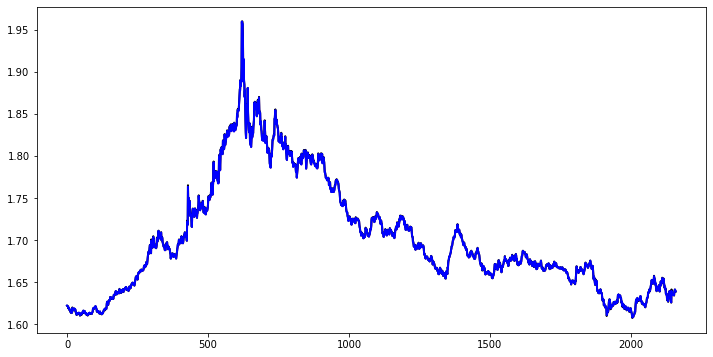

rmse:  1.2979803165933818e-06


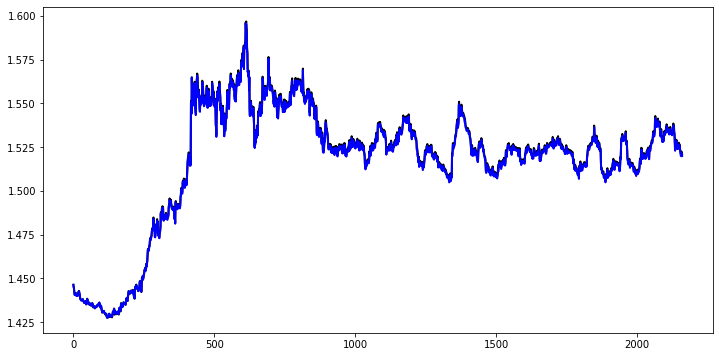

rmse:  4.5686552875395506e-07


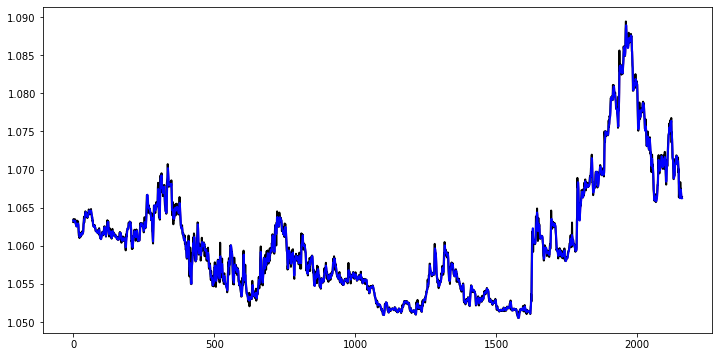

rmse:  2.6298268603033605e-07


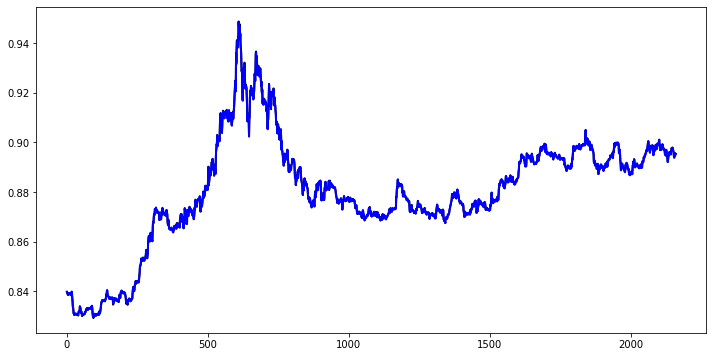

rmse:  0.007882698304768542


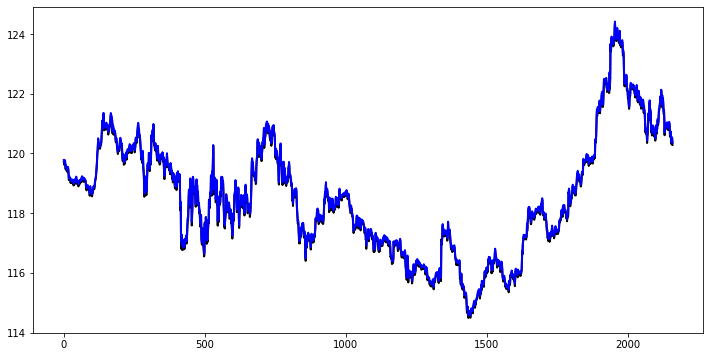

rmse:  2.2008770196111823e-07


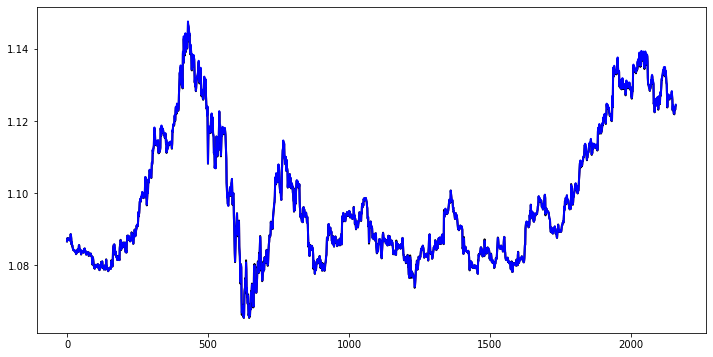

rmse:  0.00031066808611792177


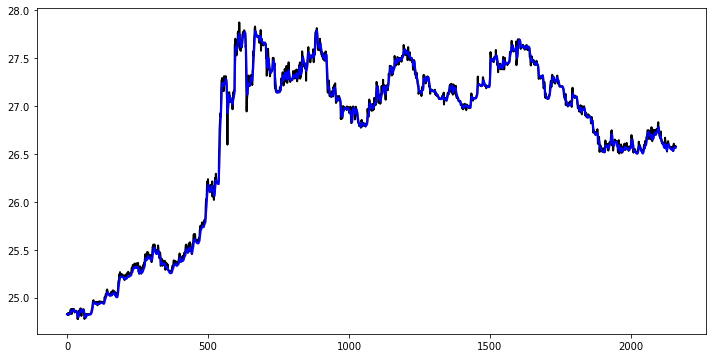

rmse:  5.713081192514189e-08


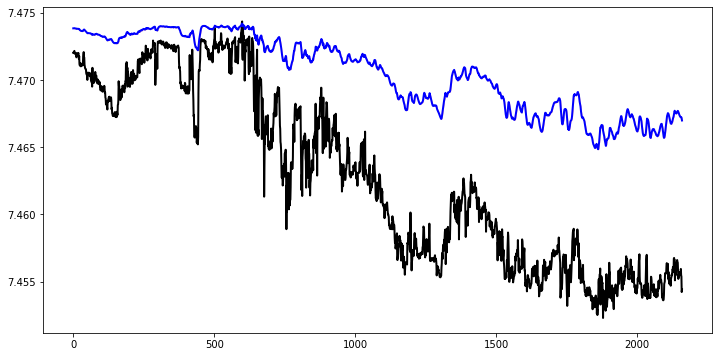

rmse:  3.272469018535382e-05


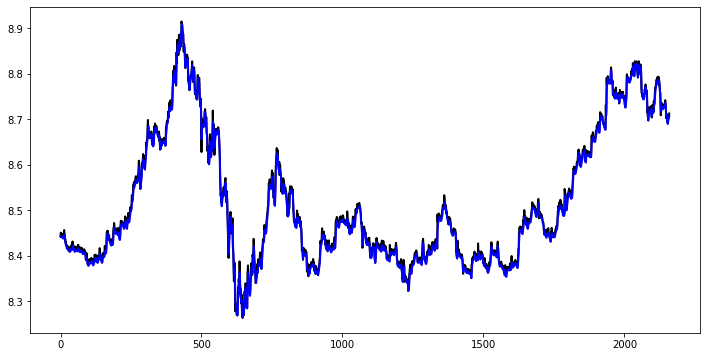

rmse:  0.11767529646334186


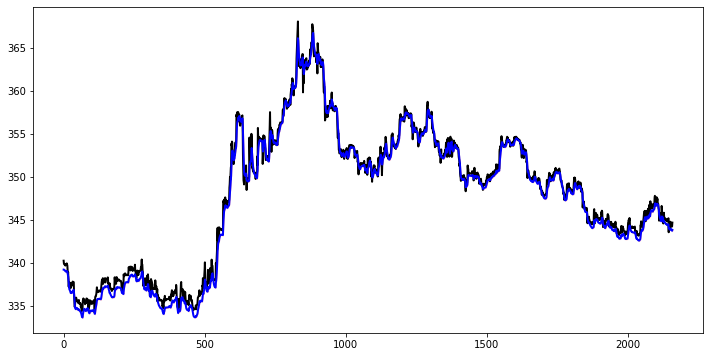

rmse:  0.001079033556719312


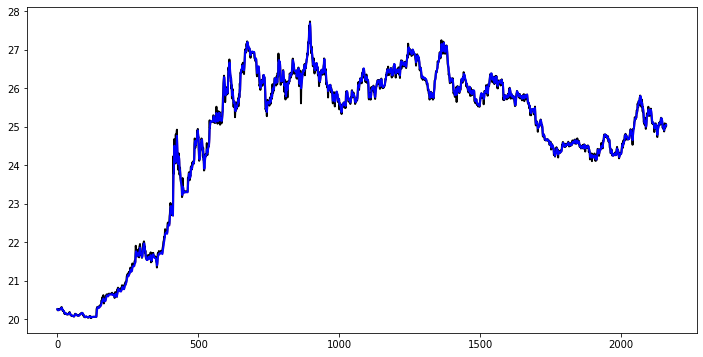

rmse:  0.0002311185461497141


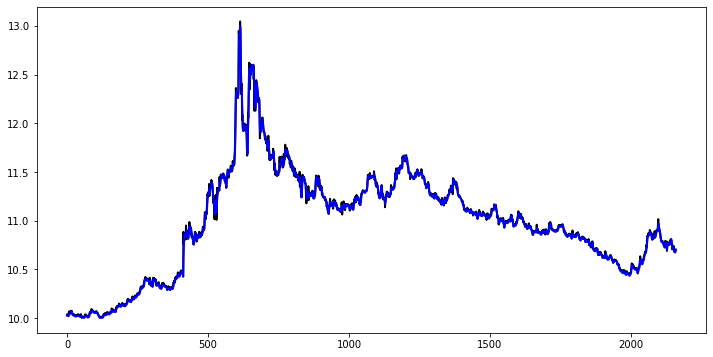

rmse:  5.032296095084855e-07


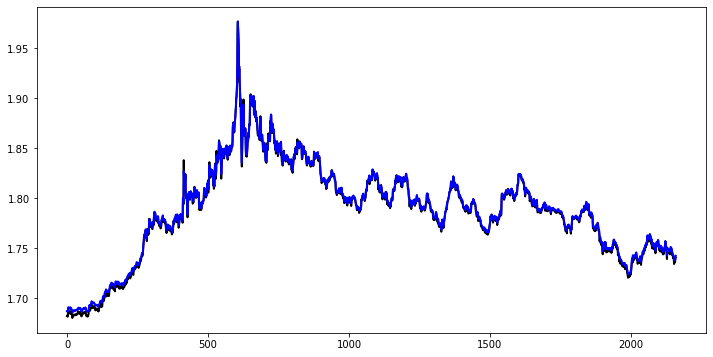

rmse:  5.6919372883887486e-06


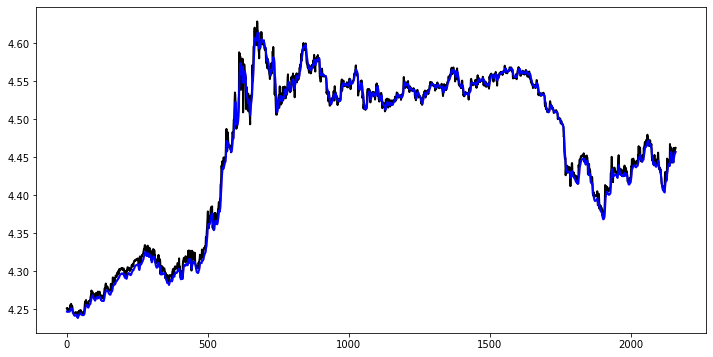

rmse:  0.0


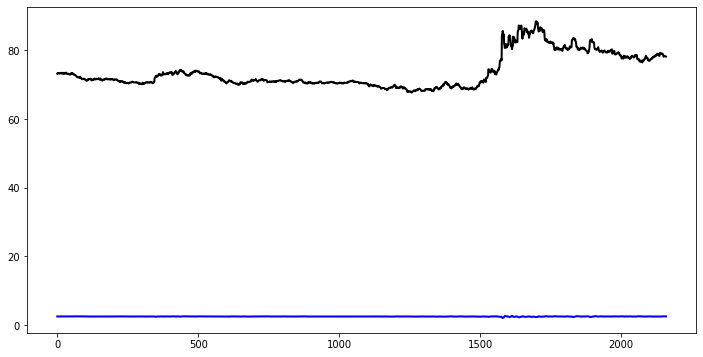

rmse:  0.0353513645647221


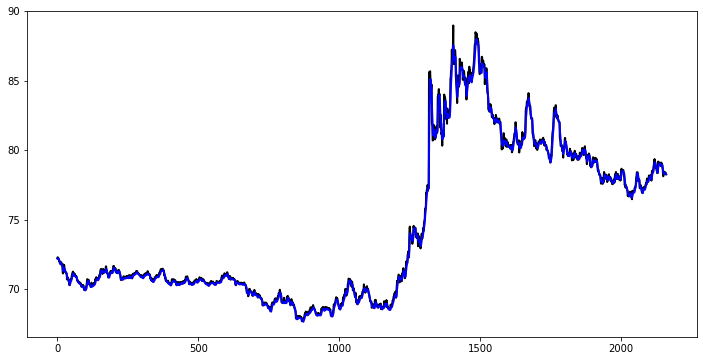

rmse:  2.6874727270660965e-05


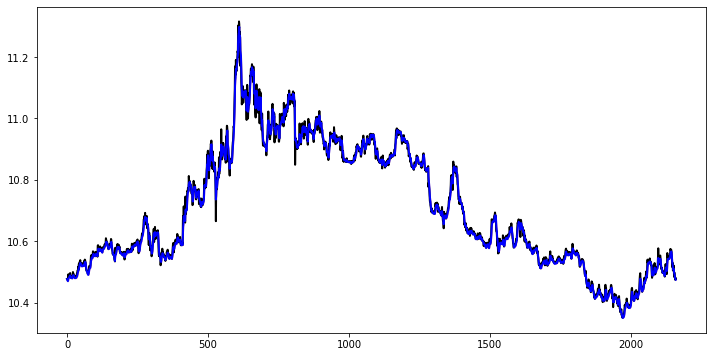

rmse:  0.00013415040029114643


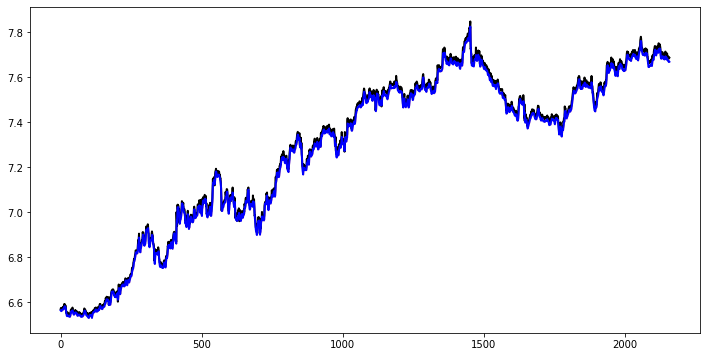

rmse:  0.0009416637892497005


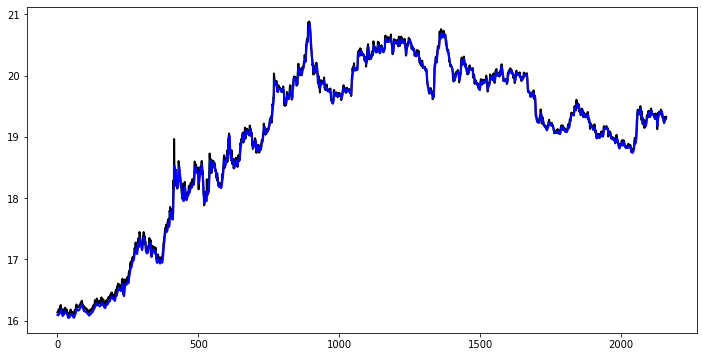

In [20]:
mse_arr = getMSE(x_train, y_train, models, scaler)
for i in range(len(curr_key)):
    xs = np.arange(int(horizon))
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(xs, y_test_inv[-horizon-1:-1, i], label='Real ' + curr_key[i], lw=2, color='black')
    ax.plot(xs, predict[-horizon:, i], label='Forecast ' + curr_key[i], lw=2, color='blue')
    

    rmse = mse_arr[i]
    print('rmse: ', rmse)

    rmse_max = [float(p) + float(rmse)/2 for p in predict[:, i]]
    rmse_min = [float(p) - float(rmse)/2 for p in predict[:, i]]

    ax.fill_between(xs, rmse_max[-horizon:], rmse_min[-horizon:], color='red', alpha=0.2)
    plt.show()